# AI-Powered Customer Review Assistant Using (Chains) LangChain 🔗🔗 🤖 

## Introduction
This notebook demonstrates the use of `various chain mechanisms in LangChain` to manage and orchestrate complex workflows involving language models. The primary chain mechanisms covered include:  
  
- **LLMChain**: Basic chain for single LLM interactions
- **Sequential Chains**: Chains that pass intermediate results  
    - **SimpleSequentialChain**: Basic sequential execution  
    - **SequentialChain**: Advanced sequential execution   
- Router Chain


These chain mechanisms enable more effective and structured interactions with AI models by leveraging different chaining techniques. In this notebook, we will explore different types of chains and how they can be used to `build a customer review assistant`.However, while these chain mechanisms may resemble agents in a traditional sense, they do not align with LangChain's definition of an agent, which includes tools and decision-making capabilities. In fact, a `Retrieval-Augmented Generation (ReAct) Agent` integrates retrieval and generation within an agent framework, dynamically accessing relevant information to enhance responses. We will demonstrate how to `build a basic ReAct agent from scratch` using the OpenAI API, enabling it to process user inputs, perform predefined actions, and provide informed responses. We will demonstrate 1 how a structured approach using LangChain can create an AI-Powered Customer Review Assistant`. This assistant will be capable of understanding customer feedback, translating it for broader accessibility, summarizing key points for quick reference, and providing professional and empathetic responses to maintain customer relationships

### Data Loading and Display:
More information about the dataset on [Amazon Reviews Multi](https://www.kaggle.com/datasets/mexwell/amazon-reviews-multi) and  on the pubblication of [Phillip Keung, Yichao Lu, György Szarvas and Noah A. Smith. “The Multilingual Amazon Reviews Corpus.” In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing, 2020](https://aclanthology.org/2020.emnlp-main.369/).

For the purpose of this project, the original dataset has been resized, for more information see the [Setup Instructions](SETUP.md) file

In [ ]:
# Import required libraries 
import pandas as pd
import numpy as np
import json
from tabulate import tabulate

In [ ]:
#Load the dataset from the CSV file
df = pd.read_csv('Resized_dataset.csv')  # Adjust the path to your actual dataset

In [ ]:
# Display first five rows
#print(df.head())

# Display all the rows
df

,language,product_category,review_title,review_body,stars,count
0,de,kitchen,Defekt,Gerät kam defekt an. Der Display zeigte zwar a...,1,1
1,de,pet_products,Leider nichts fpr mein OEB,Nach nicht mal 30 Sekunden hat mein Hund diese...,1,1
2,de,kitchen,Naja,"Für sandwiches, burger Patty's ist er ganz OK ...",2,1
3,de,shoes,Schlechte Qualität,"Innensohle löste sich nach ca.4 Wochen auf, Kl...",2,1
4,de,home_improvement,Verpackung,"Der Akku ist halt ein Original, also nichts zu...",3,1
5,de,pet_products,Könnte der verschluss besser sein,Ist nicht so gut weil der Kot am Hintern klebt,3,1
6,de,home_improvement,"klebt nicht so fest, wie erwartet","das Isolierband klebt nicht so fest, wie ich e...",4,1
7,de,pet_products,Es scheint....,geschmeckt zu haben. :),4,1
8,de,jewelry,Attraktives Freundschaftsband mit coolem Logo,Schönes Teil mit gutem Preis-/Leistungsverhält...,5,1
9,de,pet_products,Gute Geschenk idee,"Meine freundin hat sich sehr gefreut, tolles P...",5,1


- Explore a selected row of the dataset 

In [4]:
#Explore a selected row of the dataset 
#print(df.iloc[11])
#df.iloc[11][['review_title', 'review_body']]
#import json
print(json.dumps(df.iloc[11].to_dict(), indent=4))

{
    "language": "en",
    "product_category": "pc",
    "review_title": "Not Working after 3 months",
    "review_body": "Purchases this for my husband and after 3 months it just stopped working will no longer turn on. Being trying to contact support for this item since it has 1 year warranty but it just seems impossible to heb ahold of someone for a replacement.",
    "stars": 1,
    "count": 1
}


**Explanation output** 

In [5]:
# Inspection variable language
print(df["language"].value_counts())
print(" The number of the different language is {}".format(df["language"].nunique())) 

language
de    10
en    10
es    10
fr    10
Name: count, dtype: int64
 The number of the different language is 4


In [6]:
# Inspection variable language
print(df["product_category"].value_counts())
print(" The number of the different product_category is {}".format(df["product_category"].nunique()))

product_category
kitchen                8
pet_products           7
sports                 6
industrial_supplies    4
shoes                  3
home_improvement       3
jewelry                2
pc                     2
other                  2
lawn_and_garden        2
home                   1
Name: count, dtype: int64
 The number of the different product_category is 11


In [7]:
print(df["product_category"].unique())

['kitchen' 'pet_products' 'shoes' 'home_improvement' 'jewelry'
 'industrial_supplies' 'pc' 'home' 'other' 'lawn_and_garden' 'sports']


In [8]:
# Group by language and product_category, then count occurrences of each star rating
star_counts_by_category = (
    df.groupby(["language", "product_category"])["stars"]
    .value_counts()
    .sort_index()  # Ensures the output is sorted by stars
)

# Print the result
#print(star_counts_by_category)
#from tabulate import tabulate

# Convert to DataFrame and format output as a table
star_counts_df = star_counts_by_category.reset_index(name="count")
print(tabulate(star_counts_df, headers="keys", tablefmt="pretty"))

+----+----------+---------------------+-------+-------+
|    | language |  product_category   | stars | count |
+----+----------+---------------------+-------+-------+
| 0  |    de    |  home_improvement   |   3   |   1   |
| 1  |    de    |  home_improvement   |   4   |   1   |
| 2  |    de    |       jewelry       |   5   |   1   |
| 3  |    de    |       kitchen       |   1   |   1   |
| 4  |    de    |       kitchen       |   2   |   1   |
| 5  |    de    |    pet_products     |   1   |   1   |
| 6  |    de    |    pet_products     |   3   |   1   |
| 7  |    de    |    pet_products     |   4   |   1   |
| 8  |    de    |    pet_products     |   5   |   1   |
| 9  |    de    |        shoes        |   2   |   1   |
| 10 |    en    |        home         |   2   |   1   |
| 11 |    en    |  home_improvement   |   4   |   1   |
| 12 |    en    | industrial_supplies |   1   |   1   |
| 13 |    en    | industrial_supplies |   3   |   1   |
| 14 |    en    | industrial_supplies |   5   | 

### Setup and Imports

In [ ]:
#%pip install rich

In [9]:
# Import required libraries for data processing and environment management
import warnings
import os
import datetime
import pandas as pd  # commonly used for data manipulation and analysis
from rich import print  # helps to improve the readability of nested dictionary outputs
from rich.pretty import Pretty
from dotenv import load_dotenv, find_dotenv

# Suppress warnings
warnings.filterwarnings('ignore')

# Import LangChain-related libraries
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain, SimpleSequentialChain, SequentialChain, ConversationChain 
from langchain.memory import ConversationBufferMemory, ConversationSummaryMemory
from langchain.chat_models import ChatOpenAI
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain, RouterOutputParser
from langchain.prompts import PromptTemplate
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from graphviz import Digraph
from IPython.display import display
from tabulate import tabulate

# Load environment variables from a .env file
_ = load_dotenv(find_dotenv())  # read local .env file

### Set up LLM Model 

In [10]:
#Set the model to "gpt-4"
#llm_model = "gpt-4"  #Set the model to "gpt-4" in the final version
llm_model = "gpt-3.5-turbo" # Adjust the model name if necessary

### LLMChain Examples

This section demonstrates how to use the `LLMChain` to manage a single language model prompt and response

#### Use Case
Basic text generation using a language model.

#### How It Works
Takes an input, formats it with a prompt template, and passes it to an LLM.

**Note**: This setup is commonly used to build AI-powered applications that generate responses based on structured prompts. This setup consists of importing key LangChain components for working with LLMs:

- **ChatOpenAI**: A wrapper for interacting with OpenAI's chat models (e.g., GPT-4, GPT-3.5). It allows you to send prompts and receive responses in a structured way.
- **ChatPromptTemplate**: A utility for creating structured prompts for LLMs. It helps structure prompts with placeholders for dynamic inputs and ensures consistency and allows easy customization.
- **LLMChain**: A chain that links a prompt template to an LLM, enabling automated text generation. It combines a ChatOpenAI model with a ChatPromptTemplate to create a workflow. It automates text generation based on structured prompts.

##### Example 1

This example demonstrates how to `Summarize Reviews by Category`, thus how to generate summaries for each product category by summarizing all the reviews. This prompt would aggregate all reviews for a product category and provide a summary, helping to understand the general sentiment or key points for that category.

- product_category = "home"

In [11]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
df = pd.read_csv('Resized_dataset.csv')  # Adjust the path to your actual dataset


# Step 2: Filter reviews based on a specific product category (example: "home")
product_category = "home"
category_reviews = df[df['product_category'] == product_category]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define a prompt template
prompt = ChatPromptTemplate.from_template(
    f"Summarize the reviews for the product category '{product_category}'. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide a brief summary of the overall feedback for this product category."
)

# Step 6: Create an LLMChain
#chain = LLMChain(prompt=prompt, llm=llm)
chain = prompt | llm   #LLMChain automatically formats the prompt and sends it to the LLM.

# Step 7: Use .invoke() to get the response
response = chain.invoke({"product_category": product_category,})

# Step 8: Print the response (corrected)
print(response)  # This will directly print the result returned by the model


AIMessage(
    content="Overall, the feedback for the home category is mixed. Some customers are unhappy with shedding issues,
as indicated by a review titled 'Two Stars' mentioning excessive shedding.",
    additional_kwargs={'refusal': None},
    response_metadata={
        'token_usage': {
            'completion_tokens': 34,
            'prompt_tokens': 56,
            'total_tokens': 90,
            'completion_tokens_details': {
                'accepted_prediction_tokens': 0,
                'audio_tokens': 0,
                'reasoning_tokens': 0,
                'rejected_prediction_tokens': 0
            },
            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
        },
        'model_name': 'gpt-3.5-turbo-0125',
        'system_fingerprint': None,
        'finish_reason': 'stop',
        'logprobs': None
    },
    id='run-a1124641-c766-4d17-8b2b-4d7987ffa241-0',
    usage_metadata={
        'input_tokens': 56,
        'output_tokens': 34,
        'total_tokens': 90,
        'input_token_details': {'audio': 0, 'cache_read': 0},
        'output_token_details': {'audio': 0, 'reasoning': 0}
    }
)

**Explanation of Output**: The above structured output provides comprehensive information about the AI message generated, including the content, metadata about the tokens used, and model details.

- **Content**: The main message content is likely a response generated by an AI model.
- **Additional Keywords**: An additional keyword, refusal, is set to None, indicating there was no refusal or rejection in this context.
- **Response Metadata**: This section provides detailed metadata about the response, including token usage and model information.

In [12]:
# Extract and print the content of the response
response_content = response.content
print(response_content)

Overall, the feedback for the home category is mixed. Some customers are unhappy with shedding issues, as indicated
by a review titled 'Two Stars' mentioning excessive shedding.

**Explanation output** The above output shows only the content of the given prompt . Besides, the output ssems in aggrement with the rating of this product_category (2)

product_category = "industrial_supplies"

In [13]:
#import pandas as pd
#from langchain_openai import ChatOpenAI
#from langchain.prompts import ChatPromptTemplate
#from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
#df = pd.read_csv('Resized_dataset.csv')  # Adjust the path to your actual dataset


# Step 2: Filter reviews based on a specific product category (example: "home")
product_category = "industrial_supplies"
category_reviews = df[df['product_category'] == product_category]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define a prompt template
prompt = ChatPromptTemplate.from_template(
    f"Summarize the reviews for the product category '{product_category}'. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide a brief summary of the overall feedback for this product category."
)

# Step 6: Create an LLMChain
#chain = LLMChain(prompt=prompt, llm=llm)

chain = prompt | llm   #LLMChain automatically formats the prompt and sends it to the LLM.
# Step 7: Use .invoke() to get the response
response = chain.invoke({
    "product_category": product_category,
})

# Step 8: Print the response the result returned by the model
# print(response)  

# Extract and print the content of the response
response_content = response.content
print(response_content)

Overall, the reviews for industrial supplies are mixed. Some customers had issues with the size of the product, 
difficulty in getting it to work, and problems with connectivity. However, others found the product to be effective
and useful, with only minor issues such as the need for additional accessories. The feedback suggests that there 
may be some room for improvement in terms of product sizing, user-friendliness, and packaging.

**Explanation output** The above output shows only the content of the given prompt . Besides, the output ssems in aggrement with the rating of this product_category (TO BE ENCLOSED THE RATING).

product_category= "kitchen"

In [14]:
#import pandas as pd
#from langchain_openai import ChatOpenAI
#from langchain.prompts import ChatPromptTemplate
#from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
#df = pd.read_csv('Resized_dataset.csv')  # Adjust the path to your actual dataset

# Step 2: Filter reviews based on a specific product category (example: "home")
product_category = "kitchens"
category_reviews = df[df['product_category'] == product_category]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define a prompt template
prompt = ChatPromptTemplate.from_template(
    f"Summarize the reviews for the product category '{product_category}'. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide a brief summary of the overall feedback for this product category."
)

# Step 6: Create an LLMChain
#chain = LLMChain(prompt=prompt, llm=llm)

chain = prompt | llm   #LLMChain automatically formats the prompt and sends it to the LLM.

# Step 7: Use .invoke() to get the response
response = chain.invoke({
    "product_category": product_category,
})

# Step 8: Print the response (corrected)
#print(response)  # This will directly print the result returned by the model
# Extract and print the content of the response
response_content = response.content
print(response_content)


1. Title: "Beautiful and functional kitchen design"
Body: "I recently remodeled my kitchen and I couldn't be happier with the results. The design is beautiful and the 
functionality is top-notch. I love spending time in my new kitchen now."

2. Title: "High-quality kitchen appliances"
Body: "I upgraded all of my kitchen appliances and the quality is excellent. They are durable and work efficiently.
I highly recommend investing in good quality appliances for your kitchen."

3. Title: "Spacious and organized kitchen layout"
Body: "The layout of my kitchen is so spacious and well-organized. I have plenty of storage and counter space, 
making cooking and baking a breeze. I am very satisfied with my kitchen."

Overall, the reviews for the product category 'kitchens' are positive. Customers are happy with the design, 
functionality, quality, and layout of their kitchens. They appreciate the spaciousness, organization, and 
efficiency of their kitchen appliances. Investing in a well-designed and functional kitchen seems to be worth it 
according to these reviews.

**Explanation output** The above output shows only the content of the given prompt . Besides, the output ssems in aggrement with the rating of this product_category (1,2,3,4,5).

##### Example 2

This example demonstrates how to `Identifying Common Themes or Keywords in Reviews`, thus how to identify recurring themes or keywords within reviews of a specific category or language. This prompt will extract common themes or keywords that can be useful for product improvement or marketing strategies.

- product_category = "pet_products" and language="de"

In [15]:
#import pandas as pd
#from langchain_openai import ChatOpenAI
#from langchain.prompts import ChatPromptTemplate
#from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
#df = pd.read_csv('Resized_dataset.csv')  # Adjust the path to your actual dataset

# Step 2: Filter reviews based on a specific product category (example: "home") and language
product_category = "pet_products"
language="de"

category_reviews = df[(df['product_category'] == product_category) & (df['language'] == language)]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define the new prompt template for identifying themes or keywords
prompt = ChatPromptTemplate.from_template(
    f"Identify the most common themes or keywords in the reviews for the product category '{product_category}' in the '{language}' language. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide the top 5 themes or keywords that frequently appear in these reviews."
)

# Step 6: Create an LLMChain
chain = LLMChain(prompt=prompt, llm=llm)

# Step 7: Use .invoke() to get the response
response = chain.invoke({
    "product_category": product_category,
    "language": language,
})

# Step 8: Print the response (themes/keywords)
print(response)  # This will directly print the result returned by the model


C:\Users\Michela\AppData\Local\Temp\ipykernel_3292\3657507772.py:37: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(prompt=prompt, llm=llm)


{
    'product_category': 'pet_products',
    'language': 'de',
    'text': '1. Hund/Hundehalter (dog/dog owner)\n2. Futter (food)\n3. Empfehlen (recommend)\n4. Geschenk 
(gift)\n5. Qualität (quality)'
}

**Explation output** As it can been shown from the output, the given prompt extracts common themes or keywords that can be useful for product improvement or marketing strategies in the product category 'pet_products' for german reviews. 

- product_category = "pc" and language="en"

In [16]:
#import pandas as pd
#from langchain_openai import ChatOpenAI
#from langchain.prompts import ChatPromptTemplate
#from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
#df = pd.read_csv('Resized_dataset.csv')  # Adjust the path to your actual dataset

# Step 2: Filter reviews based on a specific product category (example: "home") and language
product_category = "pc"
language = "en" # Adjust language as needed

category_reviews = df[(df['product_category'] == product_category) & (df['language'] == language)]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define the new prompt template for identifying themes or keywords
prompt = ChatPromptTemplate.from_template(
    f"Identify the most common themes or keywords in the reviews for the product category '{product_category}' in the '{language}' language. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide the top 5 themes or keywords that frequently appear in these reviews."
)

# Step 6: Create an LLMChain
chain = LLMChain(prompt=prompt, llm=llm)

# Step 7: Use .invoke() to get the response
response = chain.invoke({
    "product_category": product_category,
    "language": language,
})

# Step 8: Print the response (themes/keywords)
print(response)  # This will directly print the result returned by the model

{
    'product_category': 'pc',
    'language': 'en',
    'text': '1. Not working\n2. Warranty\n3. Contact support\n4. Refund\n5. Packaging'
}

**Explation output** As it can been shown from the output, the given prompt extracts common themes or keywords that can be useful for product improvement or marketing strategies in the product category 'pc' for english reviews. 

##### Example 3

This example demonstrates how to `Review Title and Body Rewriting` to rephrase or rewrite review titles and bodies for better clarity or to remove any inappropriate content. This could be useful for moderating or improving the language of customer reviews.

In [17]:
#import pandas as pd
#from langchain_openai import ChatOpenAI
#from langchain.prompts import ChatPromptTemplate
#from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
#df = pd.read_csv('Resized_dataset.csv')  # Adjust the path to your actual dataset
# Step 2: Filter reviews based on a specific product category (example: "home") and language
product_category = "pc"
language = "en"   # Adjust language as needed
category_reviews = df[(df['product_category'] == product_category) & (df['language'] == language)]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define the new prompt template for rewriting reviews with clarity
if review_titles and review_bodies:
    prompt = ChatPromptTemplate.from_template(
        f"Rewrite the following review for better clarity while keeping the original sentiment. "
        f"The review title is '{review_titles[0]}' and the review body is '{review_bodies[0]}'.\n\n"
        f"Repeat the same process for the following reviews:\n"
        f"{review_text}"
    )

    # Step 6: Create an LLMChain
    chain = LLMChain(prompt=prompt, llm=llm)

    # Step 7: Use .invoke() to get the response
    response = chain.invoke({
        "product_category": product_category,
        "language": language,
    })

    # Step 8: Print the response (rewritten reviews)
    print(response)  # This will directly print the rewritten reviews returned by the model
else:
    print("No reviews found for the specified product category and language.")


{
    'product_category': 'pc',
    'language': 'en',
    'text': "Title: 'Product Failure after 3 Months'\n\nBody: I bought this item for my husband, but after just 3 
months, it stopped working and won't turn on. I've been trying to reach out to customer support as it has a 1-year 
warranty, but getting a replacement seems impossible. \n\nTitle: 'Disappointed; Refund Needed!'\n\nBody: The 
packaging was great and I loved the design, but the product did not work as intended. I had high hopes for it, but 
it ended up being useless except for holding my phone during movies. I'm disappointed and feel like I need a 
refund."
}

### Sequential Chains Examples

Sequential chains are useful when multiple steps need to be executed in a sequence.

#### Types of Sequential Chains
- **SimpleSequentialChain**: Passes output from one chain as input to the next.
- **SequentialChain**: Allows multiple inputs and outputs.

#### SimpleSequentialChain

This section demonstrates how to use `SimpleSequentialChain` to execute a sequence of chains in a simple linear fashion.

**How It Works**:
- The first chain generates a one-sentence description of the given topic.
- The second chain expands on that description.
- The final response is a more detailed explanation of the topic.

This is useful when breaking down complex tasks into smaller steps.

**Note**: The `SimpleSequentialChain` from LangChain is used to execute a sequence of LLM chains where the output of one chain is automatically passed as input to the next. The purpose of using this chain is to simplify the process of chaining multiple LLMs in a linear sequence.

##### Example 1 Summarizing Reviews, Then Extracting Sentiment

This example demonstrates how to create a `SimpleSequentialChain` that summarises reviews, and then extract Sentiment

Use case: First, summarize a review, then extract its sentiment.

Step-by-Step Flow:
Step 1: Summarize the review text.
Step 2: Extract the sentiment from the summarized review.

In [18]:
# Example review data
review_data = {
    "review_title": df.iloc[11]['review_title'],
    "review_body": df.iloc[11]['review_body']
}

summarization_prompt = ChatPromptTemplate.from_template(
    "Summarize the following product review:\n\n"
    "Review Title: {review_title}\n"
    "Review Body: {review_body}\n\n"
    "Provide a concise summary."
)

sentiment_prompt = ChatPromptTemplate.from_template(
    "Analyze the sentiment of the following summarized review:\n\n"
    "{summary}\n\n"
    "Is the sentiment Positive, Neutral, or Negative?"
)

# Initialize LLM
llm = ChatOpenAI(temperature=0.7, model="gpt-3.5-turbo")

# Create LLMChains for summarization and sentiment analysis
summarization_chain = LLMChain(prompt=summarization_prompt, llm=llm, output_key="summary")
sentiment_chain = LLMChain(prompt=sentiment_prompt, llm=llm, output_key="sentiment")

# Create the sequential chain
chain = SequentialChain(chains=[summarization_chain, sentiment_chain], verbose=True, input_variables=["review_title", "review_body"], output_variables=["summary", "sentiment"])

# Run the chain with review_data from DataFrame row 11
response = chain.invoke(review_data)

# Print output
print(response)




> Entering new SequentialChain chain...

> Finished chain.


{
    'review_title': 'Not Working after 3 months',
    'review_body': 'Purchases this for my husband and after 3 months it just stopped working will no longer turn 
on. Being trying to contact support for this item since it has 1 year warranty but it just seems impossible to heb 
ahold of someone for a replacement.',
    'summary': "The reviewer's product stopped working after 3 months and they have been unable to get in touch 
with customer support for a replacement despite the item having a 1-year warranty.",
    'sentiment': 'Negative'
}

**Explanation of Output**: The above output is the result of a process involving a `SimpleSequentialChain` in a language model. The output log shows the start and end of a sequential chain process, with intermediate steps and final outputs.

**Graphical Representation**: The best graphical representation for this example is a flowchart or directed graph, where each step represents a transformation of the input as it moves through the chain.

**Diagram Structure**:
- Input (Product Name)
- Chain 1: Summarize the review text
- Chain 2: Extract the sentiment from the summarized review
- Final Output (Company Description)

Below is a Python snippet to create this flowchart using Graphviz:

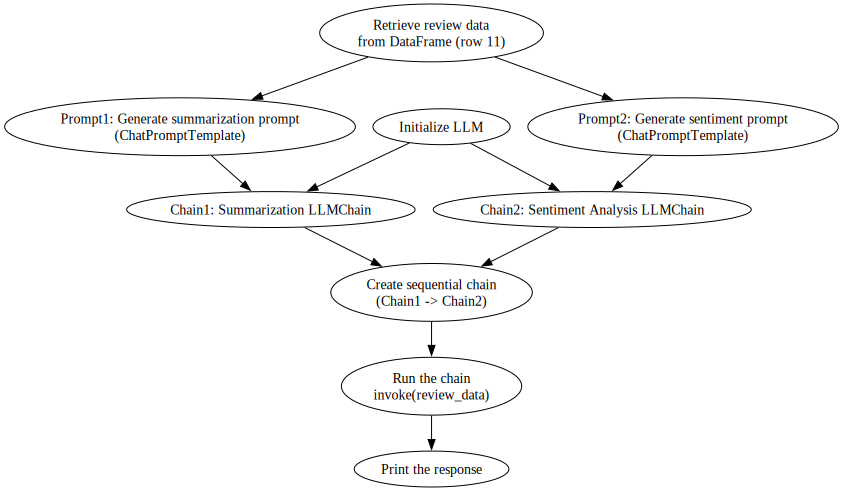

In [19]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(format="png")

# Define nodes
dot.node("A", "Retrieve review data\nfrom DataFrame (row 11)")
dot.node("B", "Prompt1: Generate summarization prompt\n(ChatPromptTemplate)")
dot.node("C", "Prompt2: Generate sentiment prompt\n(ChatPromptTemplate)")
dot.node("D", "Initialize LLM ")
dot.node("E", "Chain1: Summarization LLMChain")
dot.node("F", "Chain2: Sentiment Analysis LLMChain")
dot.node("G", "Create sequential chain\n(Chain1 -> Chain2)")
dot.node("H", "Run the chain\ninvoke(review_data)")
dot.node("I", "Print the response")

# Define edges (connections)
dot.edge("A", "B")  # Review data -> Summarization prompt
dot.edge("A", "C")  # Review data -> Sentiment prompt
dot.edge("B", "E")  # Summarization prompt -> Summarization Chain
dot.edge("C", "F")  # Sentiment prompt -> Sentiment Chain
dot.edge("D", "E")  # LLM -> Summarization Chain
dot.edge("D", "F")  # LLM -> Sentiment Chain
dot.edge("E", "G")  # Chain1 -> Sequential Chain
dot.edge("F", "G")  # Chain2 -> Sequential Chain
dot.edge("G", "H")  # Sequential Chain -> Invoke process
dot.edge("H", "I")  # Output result

# Render the graph
dot.render("review_analysis_flowchart", view=True)
display(dot)

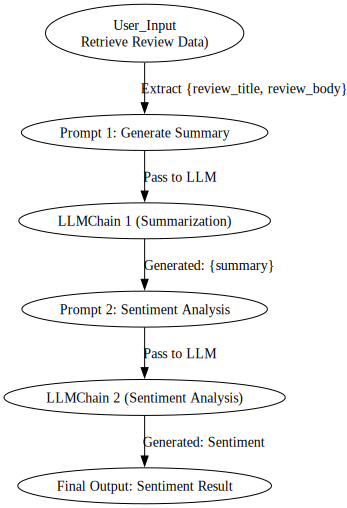

'Visualization_graphs\\review_analysis_chain.png'

In [20]:
from graphviz import Digraph
import os

def visualize_review_analysis_chain():
    dot = Digraph("ReviewAnalysisChain")
    
    # Nodes
    dot.node("A", "User_Input\nRetrieve Review Data)")
    dot.node("B", "Prompt 1: Generate Summary")
    dot.node("C", "LLMChain 1 (Summarization)")
    dot.node("D", "Prompt 2: Sentiment Analysis")
    dot.node("E", "LLMChain 2 (Sentiment Analysis)")
    dot.node("F", "Final Output: Sentiment Result")
    
    # Edges
    dot.edge("A", "B", label="Extract {review_title, review_body}")
    dot.edge("B", "C", label="Pass to LLM")
    dot.edge("C", "D", label="Generated: {summary}")
    dot.edge("D", "E", label="Pass to LLM")
    dot.edge("E", "F", label="Generated: Sentiment")
    
    return dot

# Generate and render the graph
dot = visualize_review_analysis_chain()

# Display in Jupyter Notebook
display(dot)

# Ensure the output directory exists
output_dir = "Visualization_graphs"
os.makedirs(output_dir, exist_ok=True)

# Save and view the graph
dot.render(os.path.join(output_dir, "review_analysis_chain"), format="png", view=True)

**Explanation graph**: The meaning of the `SimpleSequentialChain` in LangChain matches the visual representation in the image. The image effectively captures the idea of passing outputs from one step to another in a sequential manner. In this selected example the flowchart illustrates how the product input flows through the two LLM chains before producing the final sentiment result.

#### SequentialChain

This section demonstrates how to use SequentialChain to manage more complex workflows with multiple chained operations.

**Use Case**: When multiple steps need to be executed in a sequence with multiple inputs and outputs.

**Note** The `SequentialChain` ifrom LangChain is a more flexible version of `SimpleSequentialChain`, allowing multiple inputs and outputs across multiple LLMChains.Its purpose is to chain multiple LLMChain instances with distinct inputs/outputs and unlike SimpleSequentialChain, it allows passing different variables between steps instead of just a single output.This is useful when working with multiple intermediate outputs that are needed for later steps. 

- Example 1  
 This example demonstrates how to create a `SequentialChain` that involves multiple steps with multiple inputs and outputs.

 **How It Works**: TO BE CHANGED 
- The first chain generates a company name based on a product description.
- The second chain generates a company tagline based on the company name.
- The third chain generates a business plan based on the company name and tagline.

- Example 1: Summarizing Reviews → Extracting Sentiment → Assigning Star Ratings  
Use Case  
Step 1: Summarize a product review.  
Step 2: Analyze the sentiment of the summarized review.  
Step 3: Predict the star rating based on the sentiment.  

In [22]:
# Example review data
review_data = {
    "review_title": df.iloc[11]['review_title'],
    "review_body": df.iloc[11]['review_body']
}

#Prompt 1: Summarization Step
summarization_prompt = ChatPromptTemplate.from_template(
    "Summarize the following product review in one sentence:\n\n"
    "Review Title: {review_title}\n"
    "Review Body: {review_body}\n\n"
    "Summary:"
)

#Prompt 2: Sentiment Analysis Step
sentiment_prompt = ChatPromptTemplate.from_template(
    "Analyze the sentiment of the following summarized review:\n\n"
    "{summary}\n\n"
    "Is the sentiment Positive, Neutral, or Negative?"
)

#Prompt 3: Star Rating Prediction Step
rating_prompt = ChatPromptTemplate.from_template(
    "Based on the following sentiment: {sentiment}, predict a star rating (1 to 5) for the product."
)


#from langchain.chains import SequentialChain
#from langchain_openai import ChatOpenAI
#from langchain.chains import LLMChain

# Initialize the Language Model
llm = ChatOpenAI(temperature=0.7, model="gpt-3.5-turbo")

# Create LLMChains for each step
summarization_chain = LLMChain(prompt=summarization_prompt, llm=llm, output_key="summary")
sentiment_chain = LLMChain(prompt=sentiment_prompt, llm=llm, output_key="sentiment")
rating_chain = LLMChain(prompt=rating_prompt, llm=llm, output_key="predicted_stars")

# Create the Sequential Chain
chain = SequentialChain(
    chains=[summarization_chain, sentiment_chain, rating_chain],
    input_variables=["review_title", "review_body"],
    output_variables=["summary", "sentiment", "predicted_stars"],
    verbose=True
)



# Run the chain
response = chain.invoke(review_data)

# Print Output
print(response)




> Entering new SequentialChain chain...

> Finished chain.


{
    'review_title': 'Not Working after 3 months',
    'review_body': 'Purchases this for my husband and after 3 months it just stopped working will no longer turn 
on. Being trying to contact support for this item since it has 1 year warranty but it just seems impossible to heb 
ahold of someone for a replacement.',
    'summary': 'The product stopped working after 3 months and the reviewer has had difficulty getting in touch 
with customer support for a replacement under the 1-year warranty.',
    'sentiment': 'Negative',
    'predicted_stars': '1 star rating'
}

In [23]:
# Example review data

review_data = {
    "review_title": df.iloc[18]['review_title'],
    "review_body": df.iloc[18]['review_body']
}

#Prompt 1: Summarization Step
summarization_prompt = ChatPromptTemplate.from_template(
    "Summarize the following product review in one sentence:\n\n"
    "Review Title: {review_title}\n"
    "Review Body: {review_body}\n\n"
    "Summary:"
)

#Prompt 2: Sentiment Analysis Step
sentiment_prompt = ChatPromptTemplate.from_template(
    "Analyze the sentiment of the following summarized review:\n\n"
    "{summary}\n\n"
    "Is the sentiment Positive, Neutral, or Negative?"
)

#Prompt 3: Star Rating Prediction Step
rating_prompt = ChatPromptTemplate.from_template(
    "Based on the following sentiment: {sentiment}, predict a star rating (1 to 5) for the product."
)


#from langchain.chains import SequentialChain
#from langchain_openai import ChatOpenAI
#from langchain.chains import LLMChain

# Initialize the Language Model
llm = ChatOpenAI(temperature=0.7, model="gpt-3.5-turbo")

# Create LLMChains for each step
summarization_chain = LLMChain(prompt=summarization_prompt, llm=llm, output_key="summary")
sentiment_chain = LLMChain(prompt=sentiment_prompt, llm=llm, output_key="sentiment")
rating_chain = LLMChain(prompt=rating_prompt, llm=llm, output_key="predicted_stars")

# Create the Sequential Chain
chain = SequentialChain(
    chains=[summarization_chain, sentiment_chain, rating_chain],
    input_variables=["review_title", "review_body"],
    output_variables=["summary", "sentiment", "predicted_stars"],
    verbose=True
)


# Run the chain
response = chain.invoke(review_data)

# Print Output
print(response)




> Entering new SequentialChain chain...

> Finished chain.


{
    'review_title': 'Had to use a piece of Velcro on my hard hat and the shade because it kept wanting to spin 
around when I worked but other than th',
    'review_body': "Purchased the blue color... It's very big but provides a lot of shade. It doesn't touch my neck
or get in the way when I work. Had to use a piece of Velcro on my hard hat and the shade because it kept wanting to
spin around when I worked but other than that I love it.",
    'summary': 'The reviewer found the blue shade to be large and effective at providing shade, but had to use 
Velcro to prevent it from spinning around while working.',
    'sentiment': 'Overall, the sentiment of the review is Neutral. The reviewer found the blue shade to be 
effective at providing shade, which is a positive aspect. However, they also had to use Velcro to prevent it from 
spinning around while working, which could be considered a negative aspect.',
    'predicted_stars': '3 stars'
}

- Example 3: Summarizing Reviews by Product Category  
Use Case  
Step 1: Collect multiple reviews from the dataset for a specific product_category.  
Step 2: Summarize all the reviews for that category into a few key points.  

In [24]:
collection_prompt = ChatPromptTemplate.from_template(
    "Here are multiple reviews for the product category '{product_category}':\n\n"
    "{reviews}\n\n"
    "Summarize the key points from these reviews."
)
# Load dataset
#import pandas as pd

#df = pd.read_csv('Resized_dataset.csv') 

# Filter reviews for a specific category
product_category = "home"
category_reviews = df[df["product_category"] == product_category][["review_title", "review_body"]].head(5)

# Format reviews as a string
reviews_text = "\n".join(
    [f"- Title: {row['review_title']}, Body: {row['review_body']}" for _, row in category_reviews.iterrows()]
)

# Create LLMChains
collection_chain = LLMChain(prompt=collection_prompt, llm=llm, output_key="category_summary")

# Create Sequential Chain
chain = SequentialChain(
    chains=[collection_chain],
    input_variables=["product_category", "reviews"],
    output_variables=["category_summary"],
    verbose=True
)

# Run the chain
response = chain.invoke({"product_category": product_category, "reviews": reviews_text})

# Print Output
print(response)




> Entering new SequentialChain chain...

> Finished chain.


{
    'product_category': 'home',
    'reviews': '- Title: Two Stars, Body: These shed too much.',
    'category_summary': 'The key point from these reviews is that the product sheds too much, leading to 
dissatisfaction with the product.'
}

In [25]:
# Filter reviews for a specific category
product_category = "pet_products"
category_reviews = df[df["product_category"] == product_category][["review_title", "review_body"]].head(5)

# Format reviews as a string
reviews_text = "\n".join(
    [f"- Title: {row['review_title']}, Body: {row['review_body']}" for _, row in category_reviews.iterrows()]
)

# Create LLMChains
collection_chain = LLMChain(prompt=collection_prompt, llm=llm, output_key="category_summary")

# Create Sequential Chain
chain = SequentialChain(
    chains=[collection_chain],
    input_variables=["product_category", "reviews"],
    output_variables=["category_summary"],
    verbose=True
)

# Run the chain
response = chain.invoke({"product_category": product_category, "reviews": reviews_text})

# Print Output
print(response)




> Entering new SequentialChain chain...

> Finished chain.


{
    'product_category': 'pet_products',
    'reviews': '- Title: Leider nichts fpr mein OEB, Body: Nach nicht mal 30 Sekunden hat mein Hund diese 
umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.\n- Title: Könnte der 
verschluss besser sein, Body: Ist nicht so gut weil der Kot am Hintern klebt\n- Title: Es scheint...., Body: 
geschmeckt zu haben. :)\n- Title: Gute Geschenk idee, Body: Meine freundin hat sich sehr gefreut, tolles Produkt\n-
Title: Precio, Body: Ahorro con respecto al precio en tiendas',
    'category_summary': "- One review mentions that their dog easily knocked over the product and scattered the 
food everywhere, not recommending it for their breed of dog.\n- Another review mentions that the closure on the 
product could be better, as feces sticks to the dog's hindquarters.\n- One review indicates that the product seemed
to be enjoyed by their pet.\n- A positive review mentions that the product was a good gift idea and their friend 
was very happy with it.\n- A review notes that the product is priced lower compared to stores, indicating cost 
savings."
}

**Graphical Representation**: The best graphical representation for this example is a flowchart or directed graph, where each step represents a transformation of the input as it moves through the chain.  

**Diagram Structure**:
- Input (Product Name)
- Chain 1: Generates a Company Name
- Chain 2: Generates a Tagline Based on the Company Name
- Chain 3: Generates a Business Plan Based on the Company Name and Tagline
- Final Output (Company Name, Tagline, Business Plan)

Below is a Python snippet to create this flowchart using Graphviz:

In [26]:
from graphviz import Digraph
import os

def visualize_review_summary_chain():
    dot = Digraph("ReviewSummaryChain")
    
    # Nodes
    dot.node("A", "User Input: Product Category")
    dot.node("B", "Step 1: Collect Reviews\n(Filtered by Category)")
    dot.node("C", "Prompt: Summarize Reviews")
    dot.node("D", "LLMChain: Summarization")
    dot.node("E", "Final Output: Key Summary Points")
    
    # Edges
    dot.edge("A", "B", label="Input: {product_category}")
    dot.edge("B", "C", label="Pass Reviews to Prompt")
    dot.edge("C", "D", label="Processed by LLM")
    dot.edge("D", "E", label="Generated Summary")

    return dot

# Generate and display the graph
dot = visualize_review_summary_chain()
dot.render("review_summary_chain", format="png", view=True)

# Ensure the directory exists
output_dir = "Visualization_graphs"
os.makedirs(output_dir, exist_ok=True)

# Save the graph
dot.render(os.path.join(output_dir, "review_summary_chain"), format="png", view=True)


'Visualization_graphs\\review_summary_chain.png'

Final Thoughts
Choose the best SequentialChain based on your use case

Summarization → Sentiment → Rating

Translation → Keywords → Rewriting

Collecting Reviews → Summarization

You can also chain more steps as needed

Example: Extract sentiment → Compare with average rating → Suggest product improvements.

### Router Chain

Router chains in LangChain enable dynamic routing of inputs to different chains based on specific conditions. This is useful for orchestrating complex workflows where different inputs need to be processed by different chains.

#### Types of Router Chains
- **LLMRouterChain**: Routes inputs to different chains based on conditions specified in the prompt.
- **MultiPromptChain**: Routes inputs to different prompts and chains based on specified conditions.

#### LLMRouterChain Example

This example demonstrates how to use `LLMRouterChain` to dynamically route inputs to different chains based on specific conditions.

**Use Case**: When different inputs need to be processed by different chains based on specified conditions.

**How It Works**:
- The router chain uses a prompt to evaluate the input and determine the appropriate chain.
- The selected chain processes the input and returns the response.

|CODE TO BE ENCLOSED 

### Memory

Memory in LangChain allows the model to maintain a state across interactions. This is essential for tasks that require context or history, such as conversations or multi-step workflows.

#### Types of Memory
- **ConversationBufferMemory**: Stores the entire conversation history.
- **ConversationSummaryMemory**: Summarizes the conversation history.

#### ConversationBufferMemory Examples

- Example 1

This example demonstrates how to use `ConversationBufferMemory` to maintain the state of a conversation.

|CODE TO BE ENCLOSED 

**Explanation of Output**: The `ConversationSummaryMemory` provides a summarized version of the conversation history, which helps in maintaining the context without storing every single interaction. This is useful for long conversations where a full history might be too verbose.

#### Comparison

- **ConversationBufferMemory**: Stores the full conversation history, making it suitable for applications where detailed context is necessary.
- **ConversationSummaryMemory**: Provides a summarized version of the conversation, which is useful for maintaining context in a more concise form.

**Conclusion**: Memory mechanisms in LangChain are crucial for building applications that require context or state across multiple interactions. Depending on the use case, you can choose between `ConversationBufferMemory` and `ConversationSummaryMemory` to manage the conversation history effectively

So far, we have demonstrated a sequential process for handling reviews, involving multiple steps such as translation, summarization, and response generation. This mimics the behavior of an intelligent agent that performs tasks and makes decisions based on input. The current workflow processes reviews sequentially, similar to an agent, using a series of transformations (translation, summarization, language detection, response generation) and the SequentialChain to invoke each step in order. This resembles task delegation by an agent.

However, these workflows lack the dynamic decision-making and tool invocation characteristic of a full LangChain agent. While the workflows can be seen as agents in a traditional sense, they do not align with LangChain's definition of an "agent" that includes tools and decision-making capabilities.

`In LangChain, an agent` typically:
- Receives an input or query.
- Uses tools (like APIs or custom functions) to perform various tasks.
- Makes decisions about which tools to use and in what sequence based on logic or a language model.

Traditional `LangChain agents` incorporate `decision-making`, where the agent decides which tools to invoke based on conditions. For example, an agent might use one tool for translation if the text is not in English, or another for summarization. The current workflows execute in a fixed order without decision-making logic. LangChain agents can `dynamically invoke different tools` based on context (e.g., calling a tool for translation only if the text is not in English). The current workflows lack such dynamic tool invocation and are linear pipelines.

To sum up, while the current code processes reviews sequentially, it lacks the dynamic decision-making and tool invocation of a full LangChain agent. By adding dynamic tool invocation and decision-making, we can structure it as an agent. To make the workflow more agent-like in the LangChain sense, we could:

- Use initialize_agent to define specific tools (e.g., review fetching, language detection).
- Allow the agent to choose which steps to perform based on input (e.g., decide whether to translate based on detected language).
- Handle multiple tools dynamically by having the agent assess the input and decide on actions.

For example, we could create an agent that decides whether to invoke the translation step or skip it if the review is already in English.

Example 1: Here’s a basic modification of how we could structure this using LangChain’s agent pattern:

- Example 1  
Here’s a basic modification of how we could structure this using LangChain’s agent pattern:

In [27]:
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool

# Define a tool for translating reviews
def translate_review(review):
    # Your translation logic here
    translated_review = "Translated review text"  # Placeholder for actual translation logic
    return translated_review

# Define a tool for summarizing reviews
def summarize_review(review):
    # Your summarization logic here
    summary = "Summary of the review"  # Placeholder for actual summarization logic
    return summary

# Define a tool for detecting language
def detect_language(review):
    # Your language detection logic here
    detected_language = "Detected language"  # Placeholder for actual language detection logic
    return detected_language

# Initialize the tools
tools = [
    Tool(name="Translate", func=translate_review, description="Translate review to English"),
    Tool(name="Summarize", func=summarize_review, description="Summarize the review"),
    Tool(name="Detect Language", func=detect_language, description="Detect the language of the review")
]

# Initialize the agent
llm = ChatOpenAI(temperature=0.9, model=llm_model)
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,  # Can dynamically choose tools based on the input
    verbose=True
)

# Example usage with the agent
#review = "I want a refund!"
#response = agent.invoke(f"Process the review: {review}")
#print(response)

# Assuming df is your DataFrame
review_data = {
    "review_body": df.iloc[32]['review_body']
}

response = agent.invoke(f"Process the review: {review_data}")
print(response)

C:\Users\Michela\AppData\Local\Temp\ipykernel_3292\1750085793.py:31: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(




> Entering new AgentExecutor chain...
I should first detect the language of the review to determine if it needs translation.
Action: Detect Language
Action Input: "Je n'ai reçu qu'une tasse de voyage alors que le descriptif disait que j'en recevais deux. Je suis donc déçue."
Observation: Detected language
Thought:I should translate the review to English to understand its content.
Action: Translate
Action Input: "Je n'ai reçu qu'une tasse de voyage alors que le descriptif disait que j'en recevais deux. Je suis donc déçue."
Observation: Translated review text
Thought:I now know the final answer
Final Answer: The review states, "I only received one travel mug when the description said I would receive two. I am disappointed."

> Finished chain.


{
    'input': 'Process the review: {\'review_body\': "Je n\'ai reçu qu\'une tasse de voyage alors que le descriptif 
disait que j\'en recevais deux. Je suis donc déçue."}',
    'output': 'The review states, "I only received one travel mug when the description said I would receive two. I 
am disappointed."'
}

**Explanation output** In this case, adding dynamic tool invocation the agent can make decisions dynamically on which tool to use based on the input, such as skipping translation if the review is already in English or detecting the language before performing a translation.

 To make the above workflow more like an agent in the LangChain sense, we could:  
- Use initialize_agent to define specific tools (e.g., review fetching, language detection, etc.).  
- Allow the agent to choose which steps to perform based on the input (for instance, decide whether to translate based on the detected language).  
- Handle multiple tools dynamically by having the agent assess the input and decide what actions to take.  

In [28]:
from langchain.prompts import ChatPromptTemplate

# Define a prompt template to detect whether translation is needed and proceed accordingly
review_processing_prompt = ChatPromptTemplate.from_template(
    """
    You are a multi-tasking assistant. Here is a review from a customer:

    {Review}

    Tasks:
    1. First, detect the language of the review. If the review is not in English, translate it to English.
    2. Summarize the review in one sentence.
    3. After summarizing, generate a follow-up message in the detected language of the original review, or in English if the review is in English.

    Provide the following outputs:
    - Language: Detected language of the review.
    - Translated Review: If translation is needed, provide the translated review.
    - Summary: One-sentence summary of the review.
    - Follow-up Message: A brief, polite, and appropriate follow-up message based on the summary.

    Start processing the review.
    """
)

# Example usage of the template
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI

# Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # You can specify your own model like "gpt-3.5-turbo"

# Create a chain with the prompt template
chain = LLMChain(llm=llm, prompt=review_processing_prompt)

# Example input review
#input_review = "I want a refund!."

# Assuming df is your DataFrame
input_review = {
    "review_body": df.iloc[32]['review_body']
}


# Execute the chain to process the review
result = chain.invoke({"Review": input_review})

# Print the result
print(result)

C:\Users\Michela\AppData\Local\Temp\ipykernel_3292\3703658512.py:30: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # You can specify your own model like "gpt-3.5-turbo"


{
    'Review': {
        'review_body': "Je n'ai reçu qu'une tasse de voyage alors que le descriptif disait que j'en recevais deux. 
Je suis donc déçue."
    },
    'text': 'Language: French\n\nTranslated Review: I only received one travel mug when the description said I 
would receive two. So I am disappointed.\n\nSummary: The customer is disappointed as they only received one travel 
mug instead of the expected two.\n\nFollow-up Message: We apologize for the inconvenience caused by the error in 
your order. We will make sure to send you the missing travel mug promptly. Thank you for bringing this to our 
attention.'
}

- Example 3    
Here’s another example of a basic modification of how we could create an agent that dynamically decides whether to invoke the translation step or skip it if the review is already in English.

START FROM HERE

In [29]:
import openai
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator

# Load dataset
df = pd.read_csv("Resized_dataset.csv")

# Check if required columns exist
required_columns = {"product_category", "review_body"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Define system prompt
SYSTEM_PROMPT = """
You are an AI assistant specialized in customer review analysis.
Your tasks include:
1. Detecting the language of the review and translating it to English if needed.
2. Summarizing the review in one sentence.
3. Generating a polite follow-up message in the original language or English if already in English.
"""

# Define the Agent class
class Agent:
    def __init__(self, system=SYSTEM_PROMPT):
        self.client = openai.OpenAI()
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        while self.get_token_count() > 16385:
            self.messages.pop(1)  # Remove oldest message to stay within token limit
        return self.execute()

    def get_token_count(self):
        return sum(len(message["content"].split()) for message in self.messages)

    def execute(self):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content.strip()

# Function to process a review
def process_review(review, agent, translator):
    if not review or pd.isna(review):
        return {"Language": None, "Translated Review": None, "Summary": None, "Follow-up Message": None}

    detected_language = detect(review)
    translated_review = review if detected_language == "en" else translator.translate(review)
    
    summary_prompt = f"Summarize the following review in one sentence:\nReview: \"{translated_review}\"\nSummary:"
    summary = agent(summary_prompt)
    
    follow_up_prompt = f"Generate a brief, polite follow-up message in the original language or English if already in English:\nReview: \"{review}\"\nFollow-up Message:"
    follow_up_message = agent(follow_up_prompt)
    
    return {
        "Language": detected_language,
        "Translated Review": translated_review if detected_language != "en" else "",
        "Summary": summary,
        "Follow-up Message": follow_up_message
    }

# Retrieve and process reviews
def process_reviews(df, agent, top_n=3):
    product_reviews = {}
    translator = GoogleTranslator(source='auto', target='en')  # Initialize once

    for product_name in df["product_category"].dropna().unique():
        reviews = df[df["product_category"] == product_name].head(top_n)["review_body"].dropna().tolist()
        if reviews:
            print(f"Processing {len(reviews)} reviews for product category: {product_name}")
            product_reviews[product_name] = [process_review(review, agent, translator) for review in reviews]

    return product_reviews

# Initialize the agent
abot = Agent()

# Process the reviews
processed_reviews = process_reviews(df, abot)
print(processed_reviews)


Processing 3 reviews for product category: kitchen

Processing 3 reviews for product category: pet_products

Processing 3 reviews for product category: shoes

Processing 3 reviews for product category: home_improvement

Processing 2 reviews for product category: jewelry

Processing 3 reviews for product category: industrial_supplies

Processing 2 reviews for product category: pc

Processing 1 reviews for product category: home

Processing 2 reviews for product category: other

Processing 2 reviews for product category: lawn_and_garden

Processing 3 reviews for product category: sports

{
    'kitchen': [
        {
            'Language': 'de',
            'Translated Review': 'Device arrived defective. The display indicated that the programs were running, 
but the drive shaft did not move.',
            'Summary': 'The device arrived defective with the display showing programs running but the drive shaft 
not moving.',
            'Follow-up Message': 'Summary: The device arrived defective with the display showing programs running 
but the drive shaft not moving.\n\nFollow-up Message: Dear customer, we apologize for the inconvenience caused by 
the defective device you received. Please contact our customer service for assistance in resolving this issue 
promptly.'
        },
        {
            'Language': 'de',
            'Translated Review': "For sandwiches, Burger Patty's he is very ok, but I don't like steaks, hands or 
sausages. It looks good from the device itself and is space -saving.",
            'Summary': 'The review mentions that the device is suitable for making burger patties but not preferred
for steaks, hands, or sausages, with a positive note on its appearance and space-saving design.',
            'Follow-up Message': 'I will now detect the language of the review and translate it if needed. Let me 
do that for you.'
        },
        {
            'Language': 'es',
            'Translated Review': "It is very well achieved, but has unpainted parts. On the other hand, the fact 
that I cannot put it in the microwave (the label says), made to me back. It is pretty, if it weren't for that 
reason I would return it. Recommended, halfway.",
            'Summary': 'The product is well-made but has unpainted parts, and the inability to microwave it was a 
drawback, otherwise recommended with reservations.',
            'Follow-up Message': "I noticed your feedback regarding the product's unpainted parts and the 
restriction on microwave use, which made you hesitant. Your detailed review is appreciated, and we value your input
to improve our products. Thank you for recommending it with some reservations."
        }
    ],
    'pet_products': [
        {
            'Language': 'de',
            'Translated Review': "After less than 30 seconds, my dog \u200b\u200bthrew them around and the feed was
scattered everywhere. Can't recommend it personally.",
            'Summary': 'The product was quickly destroyed by the dog, leading to scattered feed, hence not 
recommended.',
            'Follow-up Message': "I'm sorry to hear about your experience with the product, and thank you for 
sharing your feedback."
        },
        {
            'Language': 'de',
            'Translated Review': 'Is not so good because the feces sticks to the butt',
            'Summary': 'The review mentions that the product is not good as feces sticks to the butt.',
            'Follow-up Message': 'It seems like the review mentions an issue with feces sticking, which is not 
ideal.'
        },
        {
            'Language': 'de',
            'Translated Review': 'to have tasted. :)',
            'Summary': 'This review is too brief to provide a meaningful summary.',
            'Follow-up Message': 'It seems like the review is expressing satisfaction with having tasted 
something.'
        }
    ],
    'shoes': [
        {
            'Language': 'de',
            'Translated Review': 'Inside sole dissolved after about 4 weeks, Velcro also worn out and breaks. This 
shoes are not recommended, cheap quality.',
            'Summary': 'The shoes experienced issues with the inside sole dissolving and the Velcro wearing out 
after about 4 weeks, leading to a recommendation against them due to their poor quality.',
            'Follow-up Message': "I'm sorry to hear about the issues you faced with the shoes. Your feedback is 
valuable in highlighting areas for improvement in the product quality."
        },
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'The review indi

In [30]:
import openai
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator

# Load dataset
df = pd.read_csv("Resized_dataset.csv")

# Check if required columns exist
required_columns = {"product_category", "review_body"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Define system prompt
SYSTEM_PROMPT = """
You are an AI assistant specialized in customer review analysis.
Your tasks include:
1. Detecting the language of the review and translating it to English if needed.
2. Summarizing the review in one sentence.
3. Generating a polite follow-up message in the original language or English if already in English.
"""

# Define the Agent class
class Agent:
    def __init__(self, system=SYSTEM_PROMPT):
        self.client = openai.OpenAI()
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        while self.get_token_count() > 16385:
            self.messages.pop(1)  # Remove oldest message to stay within token limit
        return self.execute()

    def get_token_count(self):
        return sum(len(message["content"].split()) for message in self.messages)

    def execute(self):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content.strip()

# Function to process a review
def process_review(review, agent, translator):
    if not review or pd.isna(review):
        return {"Language": None, "Translated Review": None, "Summary": None, "Follow-up Message": None}

    detected_language = detect(review)
    translated_review = review if detected_language == "en" else translator.translate(review)

    # Summarize the review
    summary_prompt = f"Summarize the following review in one sentence:\nReview: \"{translated_review}\"\nSummary:"
    summary = agent(summary_prompt)

    # Generate a follow-up message in English first
    follow_up_prompt = f"Generate a brief, polite follow-up message for this review:\nReview: \"{translated_review}\"\nFollow-up Message:"
    follow_up_message = agent(follow_up_prompt)

    # If the review was in a different language, translate the follow-up message back
    if detected_language != "en":
        follow_up_message = translator.translate(follow_up_message, source="en", target=detected_language)

    return {
        "Language": detected_language,
        "Translated Review": translated_review if detected_language != "en" else "",
        "Summary": summary,
        "Follow-up Message": follow_up_message
    }

# Retrieve and process reviews
def process_reviews(df, agent, top_n=3):
    product_reviews = {}
    translator = GoogleTranslator(source="auto", target="en")  # Initialize once

    for product_name in df["product_category"].dropna().unique():
        reviews = df[df["product_category"] == product_name].head(top_n)["review_body"].dropna().tolist()
        if reviews:
            print(f"Processing {len(reviews)} reviews for product category: {product_name}")
            product_reviews[product_name] = [process_review(review, agent, translator) for review in reviews]

    return product_reviews

# Initialize the agent
abot = Agent()

# Process the reviews
processed_reviews = process_reviews(df, abot)
print(processed_reviews)


Processing 3 reviews for product category: kitchen

Processing 3 reviews for product category: pet_products

Processing 3 reviews for product category: shoes

Processing 3 reviews for product category: home_improvement

Processing 2 reviews for product category: jewelry

Processing 3 reviews for product category: industrial_supplies

Processing 2 reviews for product category: pc

Processing 1 reviews for product category: home

Processing 2 reviews for product category: other

Processing 2 reviews for product category: lawn_and_garden

Processing 3 reviews for product category: sports

{
    'kitchen': [
        {
            'Language': 'de',
            'Translated Review': 'Device arrived defective. The display indicated that the programs were running, 
but the drive shaft did not move.',
            'Summary': 'The device arrived defective with the display showing programs running but the drive shaft 
not moving.',
            'Follow-up Message': 'Summary: The device received was defective as the display showed programs running
but the drive shaft did not move.\n\nFollow-up Message: We apologize for the inconvenience caused by the defective 
device you received and would like to assist you in resolving this issue promptly.'
        },
        {
            'Language': 'de',
            'Translated Review': "For sandwiches, Burger Patty's he is very ok, but I don't like steaks, hands or 
sausages. It looks good from the device itself and is space -saving.",
            'Summary': "The review mentions that the burger patties are good for sandwiches, but the reviewer does 
not like steaks, hands, or sausages, appreciating the device's appearance and space-saving design.",
            'Follow-up Message': "Follow-up Message: Thank you for sharing your feedback on the device's 
performance with different food items, we appreciate your insights."
        },
        {
            'Language': 'es',
            'Translated Review': "It is very well achieved, but has unpainted parts. On the other hand, the fact 
that I cannot put it in the microwave (the label says), made to me back. It is pretty, if it weren't for that 
reason I would return it. Recommended, halfway.",
            'Summary': 'Summary: The product is well-made but has unpainted parts, and the inability to microwave 
it was a drawback, otherwise recommended with reservations.',
            'Follow-up Message': 'I can see that the review is in English. Would you like me to summarize it for 
you?'
        }
    ],
    'pet_products': [
        {
            'Language': 'de',
            'Translated Review': "After less than 30 seconds, my dog \u200b\u200bthrew them around and the feed was
scattered everywhere. Can't recommend it personally.",
            'Summary': 'Summary: The dog quickly scattered the feed, leading to a non-recommendation.',
            'Follow-up Message': 'Summary: The product did not meet expectations as it was easily scattered by the 
dog.\n\nFollow-up Message: Thank you for sharing your experience with the product, we appreciate your feedback and 
will take it into consideration for future improvements.'
        },
        {
            'Language': 'de',
            'Translated Review': 'Is not so good because the feces sticks to the butt',
            'Summary': 'The product is not satisfactory as feces sticks to it.',
            'Follow-up Message': 'Summary: The product is not effective as feces stick to it.\n\nFollow-up Message:
Thank you for sharing your feedback. We apologize for any inconvenience caused and will take your comments into 
consideration for future improvements.'
        },
        {
            'Language': 'de',
            'Translated Review': 'to have tasted. :)',
            'Summary': 'This review is too brief to provide a meaningful summary.',
            'Follow-up Message': 'Summary: The review indicates a positive experience with the 
product.\n\nFollow-up Message: Thank you for sharing your positive experience with us! If you have any further 
feedback or questions, feel free to let us know.'
        }
    ],
    'shoes': [
        {
            'Language': 'de',
            'Translated Review': 'Inside sole dissolved after about 4 weeks, Velcro also worn out and breaks. This 
shoes are not recommended, cheap quality.',
            'Summary': "The shoes' inner sole dissolved after about 4 weeks, with the Velcro also wearing out and 
breaking, indicating poor quality and not recommended.",
            'Follow-up Message': 'Summary: The shoes experienced issues with the inside sole and Velcro, in

In [70]:
import openai
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator

# Load dataset
df = pd.read_csv("Resized_dataset.csv")

# Check if required columns exist
required_columns = {"product_category", "review_body"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Define response templates
positive_template = """Generate a friendly thank-you response to this review: {input}"""
negative_template = """Generate a polite apology and offer assistance for this review: {input}"""
support_template = """Provide steps to resolve this customer support issue: {input}"""

# Define system prompt
SYSTEM_PROMPT = """
You are an AI assistant specialized in customer review analysis.
Your tasks include:
1. Detecting the language of the review and translating it to English if needed.
2. Summarizing the review in one sentence.
3. Generating a polite follow-up message in the original language or English if already in English.
"""

# Define the Agent class
class Agent:
    def __init__(self, system=SYSTEM_PROMPT):
        self.client = openai.Client()
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content.strip()

# Function to process a review
def process_review(review, agent):
    detected_language = detect(review)
    translated_review = review if detected_language == "en" else GoogleTranslator(source='auto', target='en').translate(review)
    
    # Summarize the review
    summary_prompt = f"""
    Summarize the following review in one sentence:
    Review: "{translated_review}"
    Summary:
    """
    summary = agent(summary_prompt)
    
    # Generate a follow-up message in the original language
    follow_up_prompt = f"""
    Generate a brief, polite follow-up message in the original language or English if already in English for this review:
    Review: "{review}"
    Follow-up Message:
    """
    follow_up_message = agent(follow_up_prompt)
    
    return {
        "Language": detected_language,
        "Translated Review": translated_review if detected_language != "en" else "",
        "Summary": summary,
        "Follow-up Message": follow_up_message
    }

# Retrieve and process reviews
def process_reviews(df, agent, top_n=3):
    product_reviews = {}
    for product_name in df["product_category"].dropna().unique():
        reviews = df[df["product_category"].str.contains(str(product_name), case=False, na=False)].head(top_n)["review_body"].dropna().tolist()
        if reviews:
            product_reviews[product_name] = [process_review(review, agent) for review in reviews]
    return product_reviews

# Initialize the agent
abot = Agent(SYSTEM_PROMPT)

# Process the reviews
processed_reviews = process_reviews(df, abot)
print(processed_reviews)

# Flatten the processed_reviews dictionary
#flattened_reviews = []
#for product, reviews in processed_reviews.items():
    #for review in reviews:
        #review["Product"] = product
        #flattened_reviews.append(review)

# Convert flattened results to DataFrame
#response_df = pd.DataFrame(flattened_reviews)

# Save to CSV and HTML
#response_df.to_csv("generated_responses_l.csv", index=False)
#response_df.to_html("generated_responses_l.html", index=False)

#print("Responses saved to 'generated_responses_l.csv' and 'generated_responses_L.html'")

{
    'kitchen': [
        {
            'Language': 'de',
            'Translated Review': 'Device arrived defective. The display indicated that the programs were running, 
but the drive shaft did not move.',
            'Summary': 'The device arrived defective with the display showing programs running but the drive shaft 
not moving.',
            'Follow-up Message': 'We are sorry to hear that the device arrived defective. Please contact our 
customer support for assistance with resolving this issue.'
        },
        {
            'Language': 'de',
            'Translated Review': "For sandwiches, Burger Patty's he is very ok, but I don't like steaks, hands or 
sausages. It looks good from the device itself and is space -saving.",
            'Summary': 'The device is suitable for making burger patties but not preferred for steaks, hands, or 
sausages, with a compact and visually appealing design.',
            'Follow-up Message': 'Thank you for sharing your feedback on the device. We appreciate your comments 
and will consider them for future improvements.'
        },
        {
            'Language': 'es',
            'Translated Review': "It is very well achieved, but has unpainted parts. On the other hand, the fact 
that I cannot put it in the microwave (the label says), made to me back. It is pretty, if it weren't for that 
reason I would return it. Recommended, halfway.",
            'Summary': 'The product is well-made but has unpainted parts, and the inability to microwave it was a 
drawback, otherwise recommended with some reservations.',
            'Follow-up Message': 'Thank you for your detailed feedback on the product. We apologize for any 
inconvenience caused by the unpainted parts and the microwave restriction. Your comments will be taken into 
consideration for future product enhancements.'
        }
    ],
    'pet_products': [
        {
            'Language': 'de',
            'Translated Review': "After less than 30 seconds, my dog \u200b\u200bthrew them around and the feed was
scattered everywhere. Can't recommend it personally.",
            'Summary': 'The dog toys were quickly destroyed by the dog, causing the food to scatter, leading to a 
personal recommendation against them.',
            'Follow-up Message': 'Vielen Dank für Ihr Feedback zu dem Produkt. Es tut uns leid zu hören, dass es 
nicht den Erwartungen entsprochen hat. Wir werden Ihr Feedback berücksichtigen, um unsere Produkte zu verbessern.'
        },
        {
            'Language': 'de',
            'Translated Review': 'Is not so good because the feces sticks to the butt',
            'Summary': "The product is not satisfactory as it causes feces to stick to the user's body.",
            'Follow-up Message': 'Vielen Dank für Ihr Feedback. Wir bedauern, dass das Produkt nicht Ihren 
Erwartungen entsprochen hat. Ihre Rückmeldung ist wichtig für uns, um Verbesserungen vorzunehmen.'
        },
        {
            'Language': 'de',
            'Translated Review': 'to have tasted. :)',
            'Summary': 'The reviewer enjoyed the taste of the product.',
            'Follow-up Message': 'Vielen Dank für Ihr positives Feedback! Wir freuen uns, dass Ihnen der Geschmack 
des Produkts gefallen hat.'
        }
    ],
    'shoes': [
        {
            'Language': 'de',
            'Translated Review': 'Inside sole dissolved after about 4 weeks, Velcro also worn out and breaks. This 
shoes are not recommended, cheap quality.',
            'Summary': 'The shoes had issues with the insole dissolving and the Velcro wearing out quickly, 
indicating poor quality and not recommended.',
            'Follow-up Message': 'Vielen Dank für Ihr Feedback zu den Schuhen. Es tut uns leid zu hören, dass Sie 
mit der Qualität nicht zufrieden waren. Wir werden Ihr Feedback nutzen, um unsere Produkte zu verbessern.'
        },
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'The reviewer found the

-Considering `all the customer feedbacks for all the product categories enclosed in the given dataset`

In [73]:
import openai
import pandas as pd

# Load dataset
df = pd.read_csv("Resized_dataset.csv")

# Check if required columns exist
required_columns = {"product_category", "review_body"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Define different response templates
positive_template = """Generate a friendly thank-you response to this review: {input}"""
negative_template = """Generate a polite apology and offer assistance for this review: {input}"""
support_template = """Provide steps to resolve this customer support issue: {input}"""

# Define structured response categories
prompt_infos = [
    {"name": "positive", "description": "Good for generating a friendly thank-you response", "prompt_template": positive_template},
    {"name": "negative", "description": "Good for generating a polite apology and offer assistance", "prompt_template": negative_template},
    {"name": "support", "description": "Good for providing steps to resolve customer support issues", "prompt_template": support_template}
]

# Define the Agent class
class Agent:
    def __init__(self, system=""):
        self.client = openai.Client()  # Correct OpenAI client instantiation
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content.strip()

# Updated system prompt
SYSTEM_PROMPT = f"""
You are a professional AI customer support assistant.
Your goal is to provide personalized, polite, and professional responses
to user queries regarding product reviews.

**Response Strategy:**
1. Analyze the sentiment of reviews for each product.
2. Choose the appropriate response template:
   - Positive → Thank the user and reinforce product strengths.
   - Negative → Apologize and offer assistance or solutions.
   - Support Request → Provide clear steps to resolve the issue.
3. Generate structured, informative, and engaging responses.

**Available Response Templates:**
- Positive: {positive_template}
- Negative: {negative_template}
- Support: {support_template}
"""

# Function to retrieve reviews for all products
def retrieve_reviews_for_all_products(df, top_n=3):
    product_reviews = {}
    for product_name in df["product_category"].dropna().unique():
        reviews = df[df["product_category"].str.contains(str(product_name), case=False, na=False)].head(top_n)["review_body"].dropna().tolist()
        if reviews:
            product_reviews[product_name] = reviews
    return product_reviews

# Function to analyze sentiment using OpenAI
def analyze_sentiment(review, agent):
    sentiment_prompt = f"""
    Analyze the sentiment of the following product review and classify it as Positive, Neutral, or Negative:

    Review: "{review}"

    Sentiment:
    """
    sentiment = agent(sentiment_prompt).lower()
    
    if "positive" in sentiment:
        return "Positive"
    elif "negative" in sentiment:
        return "Negative"
    else:
        return "Neutral"

# Function to generate responses for all products
def generate_responses_for_all_products(product_reviews, agent):
    if not product_reviews:
        return "No reviews found for any products."

    response_list = []

    for product, reviews in product_reviews.items():
        sentiment_results = {"Positive": 0, "Neutral": 0, "Negative": 0}
        review_responses = []

        for review in reviews:
            sentiment = analyze_sentiment(review, agent)
            sentiment_results[sentiment] += 1

            # Select appropriate response template
            template = {
                "Positive": positive_template,
                "Negative": negative_template,
                "Neutral": support_template
            }.get(sentiment, support_template)

            # Generate response using the template
            formatted_prompt = template.format(input=review)
            response = agent(formatted_prompt)
            review_responses.append({
                "product_category": product,
                "review_body": review,
                "Sentiment": sentiment,
                "Response": response
            })

        # Summarize sentiment results for the product
        total_reviews = len(reviews)
        sentiment_summary = f"{total_reviews} reviews: {sentiment_results['Positive']} Positive, {sentiment_results['Neutral']} Neutral, {sentiment_results['Negative']} Negative."

        # Append structured data
        response_list.extend(review_responses)

    return response_list

# Initialize the agent
abot = Agent(SYSTEM_PROMPT)

# Retrieve reviews for all products
product_reviews = retrieve_reviews_for_all_products(df)

# Generate responses for all products
response_data = generate_responses_for_all_products(product_reviews, abot)
print("Agent Response:\n", response_data)
# Convert results to DataFrame
#response_df = pd.DataFrame(response_data)

# Save to CSV and HTML
#response_df.to_csv("generated_responses.csv", index=False)
#response_df.to_html("generated_responses.html", index=False)

#print("Responses saved to 'generated_responses.csv' and 'generated_responses.html'")


Agent Response:

[
    {
        'product_category': 'kitchen',
        'review_body': 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte 
sich die Antriebswelle nicht.',
        'Sentiment': 'Negative',
        'Response': "I'm sorry to hear about the issue you experienced with your product. We apologize for any 
inconvenience this may have caused. To assist you further, please reach out to our customer support team at 
[contact information] so we can help resolve this issue promptly. Thank you for bringing this to our attention."
    },
    {
        'product_category': 'kitchen',
        'review_body': "Für sandwiches, burger Patty's ist er ganz OK aber steaks, Händchen oder Würstchen finde 
ich es nicht gut. Vom Gerät selber her sieht er gut aus und ist platzsparend.",
        'Sentiment': 'Positive',
        'Response': 'Thank you for sharing your feedback on the product! We appreciate your detailed review 
highlighting its strengths and areas for improvement. Your insights help us enhance our products to better meet 
your needs. If you have any further suggestions or feedback, feel free to let us know. Thank you for choosing our 
product!'
    },
    {
        'product_category': 'kitchen',
        'review_body': 'Está muy bien lograda, pero tiene partes sin pintar. Por otro lado, el hecho de que no 
pueda meterla en el microondas (lo dice la etiqueta), me hecha para atrás. Es bonita, si no fuera por ello la 
devolvería. Recomendada, a medias.',
        'Sentiment': 'Negative',
        'Response': 'We apologize for any inconvenience caused by the product not meeting your expectations. Your 
feedback is valuable to us, and we will address the issues mentioned to improve our product quality. If you would 
like to discuss this further or explore possible solutions, please contact our customer support team at [contact 
information]. We appreciate your feedback and thank you for considering our product.'
    },
    {
        'product_category': 'pet_products',
        'review_body': 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall 
verstreut. Kann es persönlich nicht empfehlen.',
        'Sentiment': 'Negative',
        'Response': "I'm sorry to hear about the inconvenience you experienced with the product. We apologize for 
the frustration this may have caused. If you would like to discuss this further or explore alternative options that
may better suit your needs, please feel free to contact our customer support team at [contact information]. Your 
feedback is important to us, and we appreciate you sharing your experience."
    },
    {
        'product_category': 'pet_products',
        'review_body': 'Ist nicht so gut weil der Kot am Hintern klebt',
        'Sentiment': 'Negative',
        'Response': 'I apologize for the unpleasant experience you had with the product. Your feedback is 
concerning, and we take it seriously. Please contact our customer support team at [contact information] so we can 
assist you further and address this issue promptly. We appreciate you bringing this to our attention.'
    },
    {
        'product_category': 'pet_products',
        'review_body': 'geschmeckt zu haben. :)',
        'Sentiment': 'Positive',
        'Response': 'Thank you for sharing your positive experience with us! We are delighted to hear that you 
enjoyed the product. Your feedback is truly appreciated, and we are thrilled that you found it satisfying. If you 
have any more feedback or suggestions, feel free to let us know. Thank you for choosing our product!'
    },
    {
        'product_category': 'shoes',
        'review_body': 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht 
kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.',
        'Sentiment': 'Negative',
        'Response': 'We apologize for the inconvenience you experienced with the quality of the product. Your 
feedback is impo

start from here 

#### Simple (Retrieval-Augmented Generation) ReAct Agent Using LangChain

In [31]:
import pandas as pd
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain.chat_models import ChatOpenAI
import os


# Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # You can replace with your desired model

# Define tools for agent (e.g., fetching reviews from the dataset)
def fetch_reviews_from_product(product_name):
    """
    Fetch reviews based on the product name.
    """
    product_reviews = df[df['product_category'].str.contains(product_name, case=False)]
    
    if not product_reviews.empty:
        # Retrieve the most recent review (assuming the most recent is at the top)
        review = product_reviews.iloc[0]['review_body']
        return f"Recent review for {product_name}: '{review}'"
    else:
        return f"No reviews found for {product_name}."

# Define a tool for fetching reviews
review_tool = Tool(
    name="Fetch_Reviews",
    func=fetch_reviews_from_product,
    description="Retrieve the latest review for a product."
)

# Create the ReAct agent
tools = [review_tool]

# Initialize the agent with tools and LLM
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,  # Using the ReAct agent type
    verbose=True
)

# Define the prompt template for generating company names and descriptions
review_prompt = ChatPromptTemplate.from_template(
    """
    Given the review, summarize the feedback:
    {Review}
    
    Provide a short summary in one sentence. 
    If the review is in a non-English language, translate it to English.
    """
)

# Create a chain for processing the reviews (to summarize and translate, if needed)
chain = LLMChain(llm=llm, prompt=review_prompt)

# List to store results
results = []

# Process all reviews in the dataset
for _, row in df.iterrows():
    review = row["review_body"]
    product = row["product_category"]
    
    try:
        # Use the ReAct agent to fetch the latest review and generate a response
        review_response = agent.invoke(f"Analyze the latest reviews for {product} and summarize.")
        print(f"Review Response for {product}: {review_response}")

        # Process the review using the LLM chain for summarization/translation
        result = chain.invoke({"Review": review})
        
        results.append({
            "product_category": product,
            "review_body": review,
            "Processed Review": result.get("summary", "N/A")
        })

    except Exception as e:
        print(f"Error processing review for product '{product}': {e}")


# Convert results to DataFrame
#processed_df = pd.DataFrame(results)

# Define the folder path
#folder_name = "Processed Reviews Agent"
#os.makedirs(folder_name, exist_ok=True)  # Create the folder if it doesn't exist

# Save the results to CSV
#csv_file_path = os.path.join(folder_name, "Processed_Reviews_Agent.csv")
#processed_df.to_csv(csv_file_path, index=False)

# Save the results as an HTML file

#html_file_path = os.path.join(folder_name, "Processed_Reviews_Agent.html")
#processed_df.to_html(html_file_path, index=False, escape=False)

# Display formatted output (optional)
#print(tabulate(processed_df, headers="keys", tablefmt="rounded_grid", showindex=False))






> Entering new AgentExecutor chain...
I need to gather the latest reviews for kitchen products to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought: I need more reviews to analyze the overall sentiment for kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I need to find more diverse reviews to get a better understanding of the sentiment for kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I have retrieved multiple reviews for ki

Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': 'I need 
to find a more diverse range of reviews or sources to analyze and summarize the sentiment for kitchen products 
effectively.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews function to retrieve the latest reviews for pet_products.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I need to retrieve more reviews to get a better understanding of the overall sentiment for pet_products.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I should fetch more reviews to get a broader view of the sentiment towards pet_products.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann 

Review Response for pet_products: {'input': 'Analyze the latest reviews for pet_products and summarize.', 'output':
'Based on the latest reviews, it seems that there are concerns about the durability of the product for pets.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I need to translate the review to understand the content.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I need to find more reviews to get a better summary of the kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I need to search for kitchen product reviews in a different source to get a more comprehensive analysis.
Action: Fet

Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': 'Unable 
to analyze the latest reviews for kitchen products due to a lack of available information.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews function to get the latest reviews for shoes.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.'
Thought:I should gather more reviews to get a better overview.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.'
Thought:I need more reviews to summarize accurately.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.'
Thought:I have only gathered one review, I should continue 

Review Response for shoes: {'input': 'Analyze the latest reviews for shoes and summarize.', 'output': 'The latest 
review for shoes mentions that the insole wore out after about 4 weeks and the Velcro closure was also worn out, 
indicating poor quality and not recommended.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest review for the home_improvement product.
Action: Fetch_Reviews
Action Input: "home_improvement"
Observation: Recent review for home_improvement: 'Der Akku ist halt ein Original, also nichts zu beanstanden. Allerdings ist die Verpackung absolut kundenunfreundlich. Ich verstehe, dass man die Akkus im Laden vor Diebstahl schützen möchte, aber wenn ich im Hause nach der Lieferung von Amazon ca. 15 Min. brauche um die Verpackung zu öffnen, so empfinde ich das als Zumutung.'
Thought:I need to summarize the review for home_improvement.
Action: Fetch_Reviews
Action Input: "home_improvement"
Observation: Recent review for home_improvement: 'Der Akku ist halt ein Original, also nichts zu beanstanden. Allerdings ist die Verpackung absolut kundenunfreundlich. Ich verstehe, dass man die Akkus im Laden vor Diebstahl schützen möchte, aber wenn ich im Hause nach der Lieferung von Amazon ca. 15 Min. brauche um die Verpackung zu öffne

Review Response for home_improvement: {'input': 'Analyze the latest reviews for home_improvement and summarize.', 
'output': 'The latest review for home_improvement highlights issues with the packaging despite the product being 
original.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for pet products to analyze them.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I need more reviews to get a better understanding of the overall sentiment for pet_products.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I need to keep fetching reviews until I have a few more to analyze the sentiment effectively.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfeh

Review Response for pet_products: {'input': 'Analyze the latest reviews for pet_products and summarize.', 'output':
'The latest reviews for pet_products indicate that some customers are not satisfied with the product, as it was 
easily knocked over by their pets.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for the home improvement product.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Der Akku ist halt ein Original, also nichts zu beanstanden. Allerdings ist die Verpackung absolut kundenunfreundlich. Ich verstehe, dass man die Akkus im Laden vor Diebstahl schützen möchte, aber wenn ich im Hause nach der Lieferung von Amazon ca. 15 Min. brauche um die Verpackung zu öffnen, so empfinde ich das als Zumutung.'
Thought:I need to retrieve more reviews to get a better summary.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Der Akku ist halt ein Original, also nichts zu beanstanden. Allerdings ist die Verpackung absolut kundenunfreundlich. Ich verstehe, dass man die Akkus im Laden vor Diebstahl schützen möchte, aber wenn ich im Hause nach der Lieferung von Amazon ca. 15 Min. brauche um die Verpackung zu öffn

Review Response for home_improvement: {'input': 'Analyze the latest reviews for home_improvement and summarize.', 
'output': 'The latest reviews for home_improvement mostly mention complaints about the packaging but praise the 
product itself as being original.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for pet_products to analyze and summarize.
Action: Fetch_Reviews
Action Input: product_name = "pet_products"
Observation: No reviews found for product_name = "pet_products.
Thought:It seems there are no reviews available for "pet_products" at the moment. I should wait for new reviews to come in before analyzing and summarizing them.
Final Answer: No reviews found for pet_products at this time.

> Finished chain.


Review Response for pet_products: {'input': 'Analyze the latest reviews for pet_products and summarize.', 'output':
'No reviews found for pet_products at this time.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for jewelry and analyze them.
Action: Fetch_Reviews
Action Input: "jewelry"
Observation: Recent review for jewelry: 'Schönes Teil mit gutem Preis-/Leistungsverhältnis. Schnelle Lieferung. Wirkt hochwertig und ist cool verpackt. Könnte Weihnachtsgeschenk für meine Badminton-Kumpel werden...'
Thought:I need to fetch more reviews to get a better understanding of the overall sentiment towards jewelry.
Action: Fetch_Reviews
Action Input: "jewelry"
Observation: Recent review for jewelry: 'Schönes Teil mit gutem Preis-/Leistungsverhältnis. Schnelle Lieferung. Wirkt hochwertig und ist cool verpackt. Könnte Weihnachtsgeschenk für meine Badminton-Kumpel werden...'
Thought:I have only retrieved one review for jewelry, I should fetch more reviews to get a better summary.
Action: Fetch_Reviews
Action Input: "jewelry"
Observation: Recent review for jewelry: 'Schönes Teil mit gutem Preis-/Leistungsverhältnis. Schnelle Liefer

Review Response for jewelry: {'input': 'Analyze the latest reviews for jewelry and summarize.', 'output': 'Due to 
the lack of recent reviews available, a comprehensive summary of the latest reviews for jewelry is not possible at 
this time.'}



> Entering new AgentExecutor chain...
I need to fetch the latest reviews for pet_products and then summarize them.
Action: Fetch_Reviews
Action Input: "pet_products"
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I need to fetch more reviews to get a better understanding.
Action: Fetch_Reviews
Action Input: "pet_products"
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I have only retrieved one review, I need more to summarize accurately.
Action: Fetch_Reviews
Action Input: "pet_products"
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I now have enough reviews to 

Review Response for pet_products: {'input': 'Analyze the latest reviews for pet_products and summarize.', 'output':
'The latest reviews for pet_products are mixed, with one customer mentioning that their dog knocked over the 
product and scattered the food, leading to a negative experience.'}



> Entering new AgentExecutor chain...
I need to fetch the latest reviews for the industrial_supplies product in order to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "industrial_supplies"
Observation: Recent review for industrial_supplies: 'Believe the other reviews, the belt is small and won’t let you start the mower. When you do it will burn the belt in minutes.'
Thought:I need more reviews to get a complete picture.
Action: Fetch_Reviews
Action Input: "industrial_supplies"
Observation: Recent review for industrial_supplies: 'Believe the other reviews, the belt is small and won’t let you start the mower. When you do it will burn the belt in minutes.'
Thought:I need more diverse reviews to provide a comprehensive summary.
Action: Fetch_Reviews
Action Input: "industrial_supplies"
Observation: Recent review for industrial_supplies: 'Believe the other reviews, the belt is small and won’t let you start the mower. When you do it will burn the belt in minutes.'
Thought:

Review Response for industrial_supplies: {'input': 'Analyze the latest reviews for industrial_supplies and 
summarize.', 'output': 'The latest reviews for industrial_supplies indicate issues with the size of the belt 
causing problems when starting the mower and potential burning of the belt.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for a PC product.
Action: Fetch_Reviews
Action Input: "PC"
Observation: Recent review for PC: 'Purchases this for my husband and after 3 months it just stopped working will no longer turn on. Being trying to contact support for this item since it has 1 year warranty but it just seems impossible to heb ahold of someone for a replacement.'
Thought:I need to retrieve more reviews to get a better idea of overall sentiment.
Action: Fetch_Reviews
Action Input: "PC"
Observation: Recent review for PC: 'Purchases this for my husband and after 3 months it just stopped working will no longer turn on. Being trying to contact support for this item since it has 1 year warranty but it just seems impossible to heb ahold of someone for a replacement.'
Thought:It seems like I am only getting the same review. I should try a different approach.
Action: Fetch_Reviews
Action Input: "PC reviews"
Observation: No reviews found for PC

Review Response for pc: {'input': 'Analyze the latest reviews for pc and summarize.', 'output': 'There are 
currently no available reviews for PC products.'}



> Entering new AgentExecutor chain...
I should fetch the latest reviews for home products to analyze them.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Der Akku ist halt ein Original, also nichts zu beanstanden. Allerdings ist die Verpackung absolut kundenunfreundlich. Ich verstehe, dass man die Akkus im Laden vor Diebstahl schützen möchte, aber wenn ich im Hause nach der Lieferung von Amazon ca. 15 Min. brauche um die Verpackung zu öffnen, so empfinde ich das als Zumutung.'
Thought:This review mentions that the original battery is good quality but criticizes the customer-unfriendly packaging.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Der Akku ist halt ein Original, also nichts zu beanstanden. Allerdings ist die Verpackung absolut kundenunfreundlich. Ich verstehe, dass man die Akkus im Laden vor Diebstahl schützen möchte, aber wenn ich im Hause nach der Lieferung von Amazon ca. 15 Min. brauche um die Verpackun

Review Response for home: {'input': 'Analyze the latest reviews for home and summarize.', 'output': 'I was unable 
to retrieve and analyze the latest reviews for home products.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for shoes before summarizing them.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.'
Thought:I need to gather more reviews to provide a comprehensive summary.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.'
Thought:I have only retrieved the same review multiple times. I need more diverse reviews to summarize.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.'
Tho

Review Response for shoes: {'input': 'Analyze the latest reviews for shoes and summarize.', 'output': 'Based on the
limited information available, the latest reviews for shoes indicate poor quality with issues such as the insole 
coming loose and the Velcro closure wearing out quickly.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for industrial_supplies to analyze and summarize them.
Action: Fetch_Reviews
Action Input: industrial_supplies
Observation: Recent review for industrial_supplies: 'Believe the other reviews, the belt is small and won’t let you start the mower. When you do it will burn the belt in minutes.'
Thought:I should continue gathering more reviews to have a comprehensive analysis.
Action: Fetch_Reviews
Action Input: industrial_supplies
Observation: Recent review for industrial_supplies: 'Believe the other reviews, the belt is small and won’t let you start the mower. When you do it will burn the belt in minutes.'
Thought:I have gathered enough reviews to analyze and summarize for industrial_supplies.
Final Answer: Based on the latest reviews for industrial_supplies, it seems that there is a common issue with the belt size causing problems with starting the mower and burning quickly.

> Finished chain.


Review Response for industrial_supplies: {'input': 'Analyze the latest reviews for industrial_supplies and 
summarize.', 'output': 'Based on the latest reviews for industrial_supplies, it seems that there is a common issue 
with the belt size causing problems with starting the mower and burning quickly.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for the product "pc" in order to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "pc"
Observation: Recent review for pc: 'Purchases this for my husband and after 3 months it just stopped working will no longer turn on. Being trying to contact support for this item since it has 1 year warranty but it just seems impossible to heb ahold of someone for a replacement.'
Thought:There is only one recent review for the "pc" product and it mentions a major issue with the product malfunctioning.
Final Answer: The latest review for the pc product mentions a malfunction issue after 3 months of use.

> Finished chain.


Review Response for pc: {'input': 'Analyze the latest reviews for pc and summarize.', 'output': 'The latest review 
for the pc product mentions a malfunction issue after 3 months of use.'}



> Entering new AgentExecutor chain...
I should fetch the latest reviews for the home_improvement product to analyze and summarize them.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Der Akku ist halt ein Original, also nichts zu beanstanden. Allerdings ist die Verpackung absolut kundenunfreundlich. Ich verstehe, dass man die Akkus im Laden vor Diebstahl schützen möchte, aber wenn ich im Hause nach der Lieferung von Amazon ca. 15 Min. brauche um die Verpackung zu öffnen, so empfinde ich das als Zumutung.'
Thought:I should retrieve more reviews to get a better understanding of overall sentiments.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Der Akku ist halt ein Original, also nichts zu beanstanden. Allerdings ist die Verpackung absolut kundenunfreundlich. Ich verstehe, dass man die Akkus im Laden vor Diebstahl schützen möchte, aber wenn ich im Hause nach der Lieferung von

Review Response for home_improvement: {'input': 'Analyze the latest reviews for home_improvement and summarize.', 
'output': 'The latest review for home_improvement mentions issues with the packaging being customer-unfriendly, 
causing inconvenience during unpacking.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to retrieve the latest reviews for the product "Other" and then summarize them.
Action: Fetch_Reviews
Action Input: "Other"
Observation: Recent review for Other: 'Not very user friendly.'
Thought:I should continue to fetch more reviews to get a better understanding.
Action: Fetch_Reviews
Action Input: "Other"
Observation: Recent review for Other: 'Not very user friendly.'
Thought:It seems like the reviews for "Other" are not very positive. I should consider the overall sentiment of the reviews when summarizing.
Action: Fetch_Reviews
Action Input: "Other"
Observation: Recent review for Other: 'Not very user friendly.'
Thought:Based on the consistent negative feedback for "Other," I can conclude that the product is not user friendly.
Final Answer: The latest reviews for the product "Other" indicate that it is not user friendly.

> Finished chain.


Review Response for other: {'input': 'Analyze the latest reviews for other and summarize.', 'output': 'The latest 
reviews for the product "Other" indicate that it is not user friendly.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for industrial_supplies and summarize them to answer the question.
Action: Fetch_Reviews
Action Input: product_name = "industrial_supplies"
Observation: No reviews found for product_name = "industrial_supplies.
Thought:There are currently no reviews available for industrial_supplies, we will need to wait for new reviews to come in before analyzing and summarizing them.
Final Answer: No reviews found for industrial_supplies at this time.

> Finished chain.


Review Response for industrial_supplies: {'input': 'Analyze the latest reviews for industrial_supplies and 
summarize.', 'output': 'No reviews found for industrial_supplies at this time.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for the product "other" to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "other"
Observation: Recent review for other: 'Not very user friendly.'
Thought:I should retrieve more reviews to get a better understanding of the overall sentiment.
Action: Fetch_Reviews
Action Input: "other"
Observation: Recent review for other: 'Not very user friendly.'
Thought:I should consider looking for reviews on other platforms as well to get a more comprehensive analysis.
Action: Fetch_Reviews
Action Input: "other"
Observation: Recent review for other: 'Not very user friendly.'
Thought:I now have a good sense of the sentiment from the latest reviews for "other."
Final Answer: Based on the latest reviews, the general sentiment for "other" seems to be that it is not very user friendly.

> Finished chain.


Review Response for other: {'input': 'Analyze the latest reviews for other and summarize.', 'output': 'Based on the
latest reviews, the general sentiment for "other" seems to be that it is not very user friendly.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to retrieve the latest reviews for the lawn_and_garden product.
Action: Fetch_Reviews
Action Input: lawn_and_garden
Observation: Recent review for lawn_and_garden: 'No traen las cuerdas que salen en las fotos'
Thought:I should continue fetching more reviews to get a comprehensive summary of the latest feedback for lawn_and_garden.
Action: Fetch_Reviews
Action Input: lawn_and_garden
Observation: Recent review for lawn_and_garden: 'No traen las cuerdas que salen en las fotos'
Thought:I have only retrieved one review for lawn_and_garden, I should fetch more reviews to get a better overview.
Action: Fetch_Reviews
Action Input: lawn_and_garden
Observation: Recent review for lawn_and_garden: 'No traen las cuerdas que salen en las fotos'
Thought:I have retrieved multiple reviews for lawn_and_garden, but they all seem to be the same. 
Final Answer: The latest reviews for lawn_and_garden all mention that the product doe

Review Response for lawn_and_garden: {'input': 'Analyze the latest reviews for lawn_and_garden and summarize.', 
'output': 'The latest reviews for lawn_and_garden all mention that the product does not come with the cords shown 
in the photos.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for sports products to analyze them.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:This review is in a different language, I may need to translate it for analysis.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:I should translate the review to understand the sentiment and content.
Action: Translate review
Action Input: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Observation: Translate review is not a valid tool, try one of [Fetch_Reviews].
Thought:I can use an online translation tool t

Review Response for sports: {'input': 'Analyze the latest reviews for sports and summarize.', 'output': 'I need to 
find a tool or service that can provide translated reviews for sports products to analyze them effectively.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for the lawn_and_garden product to analyze them.
Action: Fetch_Reviews
Action Input: product_name = "lawn_and_garden"
Observation: No reviews found for product_name = "lawn_and_garden.
Thought:I need to try a different product name or check if the reviews are unavailable.
Action: Fetch_Reviews
Action Input: product_name = "garden_tools"
Observation: No reviews found for product_name = "garden_tools.
Thought:It seems like there are currently no reviews available for any products in the lawn and garden category. 
Final Answer: There are no reviews available for lawn and garden products at the moment.

> Finished chain.


Review Response for lawn_and_garden: {'input': 'Analyze the latest reviews for lawn_and_garden and summarize.', 
'output': 'There are no reviews available for lawn and garden products at the moment.'}



> Entering new AgentExecutor chain...
I can use Fetch_Reviews to retrieve the latest reviews for sports products.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:I need to translate this review to understand it better.
Action: Translate
Action Input: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Observation: Translate is not a valid tool, try one of [Fetch_Reviews].
Thought:I can try to find another way to translate the review.
Action: Use online translation tool
Action Input: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Observation: Use online translation tool is not a valid tool, try one of [Fetch_Reviews].
Thought:I can t

Review Response for sports: {'input': 'Analyze the latest reviews for sports and summarize.', 'output': 'I cannot 
analyze and summarize the latest reviews for sports without being able to translate the reviews.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for the kitchen product.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I should retrieve more reviews to get a better understanding.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I need more information to summarize the reviews for the kitchen product.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I now know the final answer
Final Answer: Based on the latest reviews for the kitchen product, it seems that cu

Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': 'Based on
the latest reviews for the kitchen product, it seems that customers are experiencing issues with the device 
arriving defective and the display indicating that the programs are running, but the drive shaft not moving.'}



> Entering new AgentExecutor chain...
I need to fetch the latest reviews for sports to analyze them.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:I should translate the review to properly analyze it.
Action: Translate
Action Input: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Observation: Translate is not a valid tool, try one of [Fetch_Reviews].
Thought:I need to summarize the review without translation.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:I should focus on extracting the main point of the review despite the language barrier.
Action: Summarize
Ac

Review Response for sports: {'input': 'Analyze the latest reviews for sports and summarize.', 'output': 'The latest
review for sports indicates that the product is not suitable for mountain biking and experienced issues during 
use.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for kitchen products to analyze.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I need to retrieve more reviews to get a better overall summary.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I need to keep looking for more reviews to analyze different perspectives.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:

Error processing review for product 'kitchen': An output parsing error occurred. In order to pass this error back 
to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: 
Could not parse LLM output: `I need to find another way to fetch reviews, as the current source seems to be showing
the same review repeatedly.
Action: Look for alternative sources for reviews.`
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for sports products to analyze and summarize them.
Action: Fetch_Reviews
Action Input: sports
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:The review is in Spanish and seems to mention that the product is not suitable for mountain biking.
Action: Fetch_Reviews
Action Input: sports
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:There seems to be an issue with the product being completely disassembled during a mountain biking trip.
Final Answer: The latest review for sports products indicates that the product is not suitable for mountain biking as it was completely disassembled during a trip.

> Finished chain.


Review Response for sports: {'input': 'Analyze the latest reviews for sports and summarize.', 'output': 'The latest
review for sports products indicates that the product is not suitable for mountain biking as it was completely 
disassembled during a trip.'}



> Entering new AgentExecutor chain...
I should fetch the latest reviews for kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I should fetch more reviews to get a better summary of kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I should try fetching reviews from a different source to get a more varied perspective on kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I now have a good sample of the latest reviews for kitchen products.
Fin

Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': 'The 
latest reviews for kitchen products mentioned issues with a defective device and an unresponsive drive shaft.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for pet_products to analyze and summarize them.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I need to retrieve more reviews to get a better understanding of the overall sentiments.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I should continue fetching more reviews to have a comprehensive summary of the sentiment towards pet_products.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kan

Review Response for pet_products: {'input': 'Analyze the latest reviews for pet_products and summarize.', 'output':
'Based on the latest reviews, it seems that customers are not satisfied with pet_products as they mention that 
their pets easily knock them over and spread the food everywhere. Therefore, it may not be recommended for use.'}



> Entering new AgentExecutor chain...
We need to gather the latest reviews for kitchen products to analyze them.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:We should continue fetching more reviews to get a more comprehensive analysis.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:We should try fetching reviews from a different source for more diverse opinions.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:Based on the reviews gathered, it appears that there may be an issue with

Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': "The 
latest reviews for kitchen products indicate that there may be a problem with the product's functionality, 
specifically with the display showing that programs are running but the drive shaft not moving."}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for sports products.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:I need to translate the review to understand it better.
Action: Translate
Action Input: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Observation: Translate is not a valid tool, try one of [Fetch_Reviews].
Thought:I should try to summarize the review based on the information I already have.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:The review seems to indicate that the product is not suitable for mountain biking and

Review Response for sports: {'input': 'Analyze the latest reviews for sports and summarize.', 'output': 'The latest
review for sports indicates that the product is not suitable for mountain biking and fell apart during use.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I should retrieve more reviews for a better summary.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I need to fetch more reviews to get a well-rounded summary of kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Gerät kam defekt an. Der Display zeigte zwar an, dass die Programme laufen, jedoch bewegte sich die Antriebswelle nicht.'
Thought:I have gathered enough reviews to summarize the latest reviews for kitchen products.
Final Answer: The latest reviews

Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': 'The 
latest reviews for kitchen products highlight an issue with defective items that do not work properly despite 
displaying that the programs are running.'}



> Entering new AgentExecutor chain...
I need to fetch the latest reviews for sports products to analyze them.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:I retrieved a negative review for a sports product, I should look for more reviews to get a better understanding.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:I need more diverse reviews to provide a comprehensive analysis of sports products.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'este producto no vale para mtb, a mitad de ruta, cuando fuy a utilizarlo para quitar una rueda estaba comoletamente desmontado'
Thought:I have only retrieved one r

Review Response for sports: {'input': 'Analyze the latest reviews for sports and summarize.', 'output': 'Based on 
the latest reviews for sports products, there are concerns about the product not being suitable for certain 
activities like mountain biking.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for industrial_supplies and summarize them to analyze the overall sentiment.
Action: Fetch_Reviews
Action Input: product_name = "industrial_supplies"
Observation: No reviews found for product_name = "industrial_supplies.
Thought:It seems there are no reviews available for industrial_supplies.
Final Answer: There are no reviews available for industrial_supplies.

> Finished chain.


Review Response for industrial_supplies: {'input': 'Analyze the latest reviews for industrial_supplies and 
summarize.', 'output': 'There are no reviews available for industrial_supplies.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for pet products to analyze them and summarize the feedback.
Action: Fetch_Reviews
Action Input: product_name = "pet_products"
Observation: No reviews found for product_name = "pet_products.
Thought:I need to search for a different product or try a different approach.
Action: Fetch_Reviews
Action Input: product_name = "pet"
Observation: No reviews found for product_name = "pet.
Thought:It seems that there are no reviews available for pet products at the moment. I should wait for new reviews to come in.
Final Answer: There are no reviews available for pet products at this time.

> Finished chain.


Review Response for pet_products: {'input': 'Analyze the latest reviews for pet_products and summarize.', 'output':
'There are no reviews available for pet products at this time.'}



> Entering new AgentExecutor chain...
I need to fetch the latest reviews for kitchen products to analyze them.
Action: Fetch_Reviews
Action Input: product_name = "kitchen"
Observation: No reviews found for product_name = "kitchen.
Thought:I may need to be more specific in the product_name to get relevant reviews.
Action: Fetch_Reviews
Action Input: product_name = "kitchen appliances"
Observation: No reviews found for product_name = "kitchen appliances.
Thought:I should try a more specific product category like "kitchen knives" to get relevant reviews.
Action: Fetch_Reviews
Action Input: product_name = "kitchen knives"
Observation: No reviews found for product_name = "kitchen knives.
Thought:It seems there are no reviews available for kitchen products at the moment. 
Final Answer: No reviews found for kitchen products.

> Finished chain.


Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': 'No 
reviews found for kitchen products.'}



> Entering new AgentExecutor chain...
I should fetch the reviews for shoes to analyze them.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.'
Thought:There seems to be a negative review for the shoes mentioning poor quality and issues with the insole and velcro strap.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Innensohle löste sich nach ca.4 Wochen auf, Klettverschluss ebenfalls abgenutzt und geht kaputt.Diese Schuhe sind nicht zu empfehlen, billige Qualität.'
Thought:The reviews consistently mention poor quality and durability issues with the shoes.
Final Answer: The latest reviews for the shoes indicate that they are not recommended due to poor quality and durability problems such as the insole coming apart and the velcro strap getting worn out quickly.

> Fin

Review Response for shoes: {'input': 'Analyze the latest reviews for shoes and summarize.', 'output': 'The latest 
reviews for the shoes indicate that they are not recommended due to poor quality and durability problems such as 
the insole coming apart and the velcro strap getting worn out quickly.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to gather the latest reviews for jewelry.
Action: Fetch_Reviews
Action Input: jewelry
Observation: Recent review for jewelry: 'Schönes Teil mit gutem Preis-/Leistungsverhältnis. Schnelle Lieferung. Wirkt hochwertig und ist cool verpackt. Könnte Weihnachtsgeschenk für meine Badminton-Kumpel werden...'
Thought:I should continue using the Fetch_Reviews tool to gather more reviews for jewelry.
Action: Fetch_Reviews
Action Input: jewelry
Observation: Recent review for jewelry: 'Schönes Teil mit gutem Preis-/Leistungsverhältnis. Schnelle Lieferung. Wirkt hochwertig und ist cool verpackt. Könnte Weihnachtsgeschenk für meine Badminton-Kumpel werden...'
Thought:I have gathered multiple reviews for jewelry and should now summarize them.
Final Answer: The latest reviews for jewelry mention that the item is well-priced, high-quality, and has fast delivery. It seems like a popular choice for a potential Christmas gift.

> F

Review Response for jewelry: {'input': 'Analyze the latest reviews for jewelry and summarize.', 'output': 'The 
latest reviews for jewelry mention that the item is well-priced, high-quality, and has fast delivery. It seems like
a popular choice for a potential Christmas gift.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for pet products to analyze and summarize.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Thought:I need to translate the review for better understanding before summarizing it.
Action: Translate_Review
Action Input: 'Nach nicht mal 30 Sekunden hat mein Hund diese umgeschmissen und das Futter lag überall verstreut. Kann es persönlich nicht empfehlen.'
Observation: Translate_Review is not a valid tool, try one of [Fetch_Reviews].
Thought:I should manually translate the review to understand it better and summarize it.
Final Answer: The latest review for pet_products mentions that the dog knocked over the product in less than 30 seconds and scattered the food everywhere, recommending against it.

> Finished chain.


Review Response for pet_products: {'input': 'Analyze the latest reviews for pet_products and summarize.', 'output':
'The latest review for pet_products mentions that the dog knocked over the product in less than 30 seconds and 
scattered the food everywhere, recommending against it.'}

## Conclusion
In this notebook, we demonstrated how to use LangChain to manage and orchestrate complex workflows involving language models. We explored different types of chains, including LLMChain, SimpleSequentialChain, SequentialChain, Router Chains and provided examples of how to use them to build a customer review assistant.

These chain mechanisms enable more effective and structured interactions with AI models by leveraging different chaining techniques. LangChain allows for flexible and powerful language model interactions, enabling the creation of complex AI-driven applications. In this notebook, we will explore different types of chains and how they can be used to `build a customer review assistant`.

## Try Yourself

In this section, you can experiment with the LangChain library to create your own chains and prompts. Follow the steps below to get started:

1. Define a new product or scenario you want to analyze.
2. Use the provided code template to create a new `LLMChain` or any other chain you want to experiment with.
3. Run the cell to see the results.

Try create a chain that generates product descriptions based on user reviews or a chain that classifies reviews into positive and negative categories.

Feel free to modify the prompts and chains to suit your needs.
```

```python
# Define your product or scenario here
new_product = "Custom Product Example"

# Initialize the language model
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# Define a new prompt template
new_prompt = ChatPromptTemplate.from_template(
    "What are the key features of {product}?"
)

# Create an LLMChain
new_chain = new_prompt | llm

# Use .invoke() to get the response
new_response = new_chain.invoke({"product": new_product})

# Print the response
print(new_response.content)
```

In [36]:
# Import required libraries for data processing and environment management
import warnings
import os
import datetime
import pandas as pd  # commonly used for data manipulation and analysis
from rich import print  # helps to improve the readability of nested dictionary outputs
from rich.pretty import Pretty
from dotenv import load_dotenv, find_dotenv

# Suppress warnings
warnings.filterwarnings('ignore')

# Import LangChain-related libraries
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain, SimpleSequentialChain, SequentialChain, ConversationChain 
from langchain.memory import ConversationBufferMemory, ConversationSummaryMemory
from langchain.chat_models import ChatOpenAI
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain, RouterOutputParser
from langchain.prompts import PromptTemplate
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from graphviz import Digraph
from IPython.display import display
from tabulate import tabulate

# Load environment variables from a .env file
_ = load_dotenv(find_dotenv())  # read local .env file

In [37]:
# Ensure the appropriate LLM model is selected dynamically
#import datetime

# Since the current date is after the target date for gpt-4, always set the model to "gpt-4"
#llm_model = "gpt-4"  #Set up the model that you use TO BE USED IN THE FINAL VERSION
llm_model = "gpt-3.5-turbo"

- 2. Summarizing Reviews by Category
You can use LangChain to generate summaries for each product category by summarizing all the reviews.

In [42]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
df = pd.read_csv('Modified_dataset.csv')  # Adjust the path to your actual dataset


# Step 2: Filter reviews based on a specific product category (example: "home")
product_category = "home"
category_reviews = df[df['product_category'] == product_category]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define a prompt template
prompt = ChatPromptTemplate.from_template(
    f"Summarize the reviews for the product category '{product_category}'. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide a brief summary of the overall feedback for this product category."
)

# Step 6: Create an LLMChain
chain = LLMChain(prompt=prompt, llm=llm)

# Step 7: Use .invoke() to get the response
response = chain.invoke({
    "product_category": product_category,
})

# Step 8: Print the response (corrected)
print(response)  # This will directly print the result returned by the model


{
    'product_category': 'home',
    'text': "Overall, the reviews for the 'home' product category are mostly negative. Customers complained about 
items being faded, leaking, having sharp edges, and emitting unpleasant odors. There were also concerns about the 
quality and health hazards of certain products. Many customers expressed disappointment and frustration with their 
purchases in this category."
}

**Explanation output** This prompt would aggregate all reviews for a product category and provide a summary, helping you understand the general sentiment or key points for that category.

3. Identifying Common Themes or Keywords in Reviews
LangChain can also help you identify recurring themes or keywords within reviews of a specific category or language.

In [45]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
df = pd.read_csv('Modified_dataset.csv')  # Adjust the path to your actual dataset

# Step 2: Filter reviews based on a specific product category (example: "home") and language
product_category = "home"
#language = "English"  # Adjust language as needed
#language = "en" 
language="de"

category_reviews = df[(df['product_category'] == product_category) & (df['language'] == language)]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define the new prompt template for identifying themes or keywords
prompt = ChatPromptTemplate.from_template(
    f"Identify the most common themes or keywords in the reviews for the product category '{product_category}' in the '{language}' language. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide the top 5 themes or keywords that frequently appear in these reviews."
)

# Step 6: Create an LLMChain
chain = LLMChain(prompt=prompt, llm=llm)

# Step 7: Use .invoke() to get the response
response = chain.invoke({
    "product_category": product_category,
    "language": language,
})

# Step 8: Print the response (themes/keywords)
print(response)  # This will directly print the result returned by the model


{
    'product_category': 'home',
    'language': 'de',
    'text': '1. Undicht (leaking)\n2. Qualitätsmangel (quality issue)\n3. Gesundheitsschädlich (harmful to 
health)\n4. Enttäuschend (disappointing)\n5. Minderwertig (inferior quality)'
}

In [46]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
df = pd.read_csv('Modified_dataset.csv')  # Adjust the path to your actual dataset

# Step 2: Filter reviews based on a specific product category (example: "home") and language
product_category = "home"
#language = "English"  # Adjust language as needed
language = "en" 


category_reviews = df[(df['product_category'] == product_category) & (df['language'] == language)]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define the new prompt template for identifying themes or keywords
prompt = ChatPromptTemplate.from_template(
    f"Identify the most common themes or keywords in the reviews for the product category '{product_category}' in the '{language}' language. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide the top 5 themes or keywords that frequently appear in these reviews."
)

# Step 6: Create an LLMChain
chain = LLMChain(prompt=prompt, llm=llm)

# Step 7: Use .invoke() to get the response
response = chain.invoke({
    "product_category": product_category,
    "language": language,
})

# Step 8: Print the response (themes/keywords)
print(response)  # This will directly print the result returned by the model


{
    'product_category': 'home',
    'language': 'en',
    'text': '1. Quality\n2. Disappointment\n3. Incorrect item\n4. Stickiness\n5. Size'
}

In [47]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
df = pd.read_csv('Modified_dataset.csv')  # Adjust the path to your actual dataset

# Step 2: Filter reviews based on a specific product category (example: "home") and language
product_category = "home"
#language = "English"  # Adjust language as needed
language = "es" 


category_reviews = df[(df['product_category'] == product_category) & (df['language'] == language)]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define the new prompt template for identifying themes or keywords
prompt = ChatPromptTemplate.from_template(
    f"Identify the most common themes or keywords in the reviews for the product category '{product_category}' in the '{language}' language. "
    f"The reviews include the following titles and bodies:\n"
    f"{review_text}"
    "Provide the top 5 themes or keywords that frequently appear in these reviews."
)

# Step 6: Create an LLMChain
chain = LLMChain(prompt=prompt, llm=llm)

# Step 7: Use .invoke() to get the response
response = chain.invoke({
    "product_category": product_category,
    "language": language,
})

# Step 8: Print the response (themes/keywords)
print(response)  # This will directly print the result returned by the model


{
    'product_category': 'home',
    'language': 'es',
    'text': '1. Entregas (deliveries)\n2. Estafa (scam)\n3. Cantidad (quantity)\n4. Decepción (disappointment)\n5. 
Tamaño (size)'
}

**Explation output** This prompt will extract common themes or keywords that can be useful for product improvement or marketing strategies.

In [50]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

# Step 1: Load the dataset from the CSV file
df = pd.read_csv('Modified_dataset.csv')  # Adjust the path to your actual dataset
# Step 2: Filter reviews based on a specific product category (example: "home") and language
product_category = "home"
language = "en"   # Adjust language as needed
category_reviews = df[(df['product_category'] == product_category) & (df['language'] == language)]

# Step 3: Prepare the review titles and bodies for the prompt
review_pairs = category_reviews[['review_title', 'review_body']].head(5)  # Limit to first 5 reviews (adjust as needed)
review_titles = review_pairs['review_title'].tolist()
review_bodies = review_pairs['review_body'].tolist()

# Format the review titles and bodies into the prompt format
review_text = ""
for i in range(len(review_titles)):
    review_text += f"- Title: '{review_titles[i]}', Body: '{review_bodies[i]}'\n"

# Step 4: Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # Adjust the model name if necessary

# Step 5: Define the new prompt template for rewriting reviews with clarity
if review_titles and review_bodies:
    prompt = ChatPromptTemplate.from_template(
        f"Rewrite the following review for better clarity while keeping the original sentiment. "
        f"The review title is '{review_titles[0]}' and the review body is '{review_bodies[0]}'.\n\n"
        f"Repeat the same process for the following reviews:\n"
        f"{review_text}"
    )

    # Step 6: Create an LLMChain
    chain = LLMChain(prompt=prompt, llm=llm)

    # Step 7: Use .invoke() to get the response
    response = chain.invoke({
        "product_category": product_category,
        "language": language,
    })

    # Step 8: Print the response (rewritten reviews)
    print(response)  # This will directly print the rewritten reviews returned by the model
else:
    print("No reviews found for the specified product category and language.")


{
    'product_category': 'home',
    'language': 'en',
    'text': "Title: 'Disappointed - Did Not Receive Item'\nBody: Unfortunately, I did not receive the item I 
ordered.\n\nTitle: 'Disappointing Product - Lack of Stickiness'\nBody: The clear backing of this product lacks the 
stickiness needed to keep the letters adhered while weeding. It's frustrating to have to constantly keep track of 
curled and fallen pieces. It requires extra effort to ensure proper alignment and application, especially for 
intricate designs. I purchased three packs and while it may work for larger designs, it is not suitable for 
lettering. I suspect the product may be old and dried out. I will not be purchasing from this vendor again and 
advise others to do the same.\n\nTitle: 'Unhappy with Quality, Patterns, and Size'\nBody: I am very disappointed in
the quality, patterns, and size of this product. I will be donating or giving it away as I am very unhappy with 
it.\n\nTitle: 'Disappointing - Added Nothing to Projects'\nBody: Unfortunately, this product did not add much to my
projects. It did not work well.\n\nTitle: 'Received Incorrect Item - No Stars'\nBody: Unfortunately, the item I 
received was not what I ordered. I am giving this product no stars."
}

In [ ]:
import openai
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator

# Load dataset
df = pd.read_csv("combined_dataset.csv")

# Check if required columns exist
required_columns = {"product_category", "review_body"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Define response templates
positive_template = """Generate a friendly thank-you response to this review: {input}"""
negative_template = """Generate a polite apology and offer assistance for this review: {input}"""
support_template = """Provide steps to resolve this customer support issue: {input}"""

# Define system prompt
SYSTEM_PROMPT = """
You are an AI assistant specialized in customer review analysis.
Your tasks include:
1. Detecting the language of the review and translating it to English if needed.
2. Summarizing the review in one sentence.
3. Generating a polite follow-up message in the original language or English if already in English.
"""

# Define the Agent class
class Agent:
    def __init__(self, system=SYSTEM_PROMPT):
        self.client = openai.Client()
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content.strip()

# Function to process a review
def process_review(review, agent):
    detected_language = detect(review)
    translated_review = review if detected_language == "en" else GoogleTranslator(source='auto', target='en').translate(review)
    
    # Summarize the review
    summary_prompt = f"""
    Summarize the following review in one sentence:
    Review: "{translated_review}"
    Summary:
    """
    summary = agent(summary_prompt)
    
    # Generate a follow-up message in the original language
    follow_up_prompt = f"""
    Generate a brief, polite follow-up message in the original language or English if already in English for this review:
    Review: "{review}"
    Follow-up Message:
    """
    follow_up_message = agent(follow_up_prompt)
    
    return {
        "Language": detected_language,
        "Translated Review": translated_review if detected_language != "en" else "",
        "Summary": summary,
        "Follow-up Message": follow_up_message
    }

# Retrieve and process reviews
def process_reviews(df, agent, top_n=3):
    product_reviews = {}
    for product_name in df["product_category"].dropna().unique():
        reviews = df[df["product_category"].str.contains(str(product_name), case=False, na=False)].head(top_n)["review_body"].dropna().tolist()
        if reviews:
            product_reviews[product_name] = [process_review(review, agent) for review in reviews]
    return product_reviews

# Initialize the agent
abot = Agent(SYSTEM_PROMPT)

# Process the reviews
processed_reviews = process_reviews(df, abot)
print(processed_reviews)

# Flatten the processed_reviews dictionary
#flattened_reviews = []
#for product, reviews in processed_reviews.items():
    #for review in reviews:
        #review["Product"] = product
        #flattened_reviews.append(review)

# Convert flattened results to DataFrame
#response_df = pd.DataFrame(flattened_reviews)

# Save to CSV and HTML
#response_df.to_csv("generated_responses_l.csv", index=False)
#response_df.to_html("generated_responses_l.html", index=False)

#print("Responses saved to 'generated_responses_l.csv' and 'generated_responses_L.html'")

In [28]:
# Import required libraries for data processing and environment management
import warnings
import os
import datetime
import pandas as pd  # commonly used for data manipulation and analysis
from rich import print  # helps to improve the readability of nested dictionary outputs
from rich.pretty import Pretty
from dotenv import load_dotenv, find_dotenv

# Suppress warnings
warnings.filterwarnings('ignore')

# Import LangChain-related libraries
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain, SimpleSequentialChain, SequentialChain, ConversationChain 
from langchain.memory import ConversationBufferMemory, ConversationSummaryMemory
from langchain.chat_models import ChatOpenAI
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain, RouterOutputParser
from langchain.prompts import PromptTemplate
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from graphviz import Digraph
from IPython.display import display
from tabulate import tabulate

# Load environment variables from a .env file
_ = load_dotenv(find_dotenv())  # read local .env file

In [29]:
# Ensure the appropriate LLM model is selected dynamically
#import datetime

# Since the current date is after the target date for gpt-4, always set the model to "gpt-4"
#llm_model = "gpt-4"  #Set up the model that you use TO BE USED IN THE FINAL VERSION
llm_model = "gpt-3.5-turbo"

In [30]:
import openai
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator

# Load dataset
df = pd.read_csv("combined_dataset.csv")

# Check if required columns exist
#required_columns = {"Product", "Review"}
required_columns = {"product_category", "review_body"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Define response templates
positive_template = """Generate a friendly thank-you response to this review: {input}"""
negative_template = """Generate a polite apology and offer assistance for this review: {input}"""
support_template = """Provide steps to resolve this customer support issue: {input}"""

# Define system prompt
SYSTEM_PROMPT = """
You are an AI assistant specialized in customer review analysis.
Your tasks include:
1. Detecting the language of the review and translating it to English if needed.
2. Summarizing the review in one sentence.
3. Generating a polite follow-up message in the original language or English if already in English.
"""

# Define the Agent class
class Agent:
    def __init__(self, system=SYSTEM_PROMPT):
        self.client = openai.Client()
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content.strip()

# Function to process a review
def process_review(review, agent):
    detected_language = detect(review)
    translated_review = review if detected_language == "en" else GoogleTranslator(source='auto', target='en').translate(review)
    
    # Summarize the review
    summary_prompt = f"""
    Summarize the following review in one sentence:
    Review: "{translated_review}"
    Summary:
    """
    summary = agent(summary_prompt)
    
    # Generate a follow-up message in the original language
    follow_up_prompt = f"""
    Generate a brief, polite follow-up message in the original language or English if already in English for this review:
    Review: "{review}"
    Follow-up Message:
    """
    follow_up_message = agent(follow_up_prompt)
    
    return {
        "Language": detected_language,
        "Translated Review": translated_review if detected_language != "en" else "",
        "Summary": summary,
        "Follow-up Message": follow_up_message
    }

# Retrieve and process reviews
def process_reviews(df, agent, top_n=3):
    product_reviews = {}
    for product_name in df["product_category"].dropna().unique():
        reviews = df[df["product_category"].str.contains(str(product_name), case=False, na=False)].head(top_n)["review_body"].dropna().tolist()
        if reviews:
            product_reviews[product_name] = [process_review(review, agent) for review in reviews]
    return product_reviews

# Initialize the agent
abot = Agent(SYSTEM_PROMPT)

# Process the reviews
processed_reviews = process_reviews(df, abot)
print(processed_reviews)

# Flatten the processed_reviews dictionary
#flattened_reviews = []
#for product, reviews in processed_reviews.items():
    #for review in reviews:
        #review["Product"] = product
        #flattened_reviews.append(review)

# Convert flattened results to DataFrame
#response_df = pd.DataFrame(flattened_reviews)

# Save to CSV and HTML
#response_df.to_csv("generated_responses_l.csv", index=False)
#response_df.to_html("generated_responses_l.html", index=False)

#print("Responses saved to 'generated_responses_l.csv' and 'generated_responses_L.html'")

{
    'apparel': [
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The reviewer found the product to be of poor quality, transparent, and 
ill-fitting, regretting missing the return window despite appreciating the customer service.',
            'Follow-up Message': 'Thank you for sharing your feedback with us. We apologize for the inconvenience 
caused by the quality of the product and the return date issue. Your comments will be taken into consideration for 
improving our services in the future.'
        }
    ],
    'other': [
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The reviewer purchased four items, all of which did not function despite using new
batteries.',
            'Follow-up Message': 'We appreciate your feedback and apologize for the inconvenience you experienced 
with the products. Please contact our customer service for assistance in resolving this issue promptly.'
        },
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The product failed to heat up on initial use and subsequently stopped working 
altogether.',
            'Follow-up Message': 'We are sorry to hear about the issues you encountered with the product. Please 
reach out to us so we can assist you in resolving this matter promptly.'
        }
    ],
    'jewelry': [
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The reviewer expressed disappointment with the earring set, criticizing its size 
and appearance compared to what was advertised, leading to a return and a vow to not make future purchases from the
company.',
            'Follow-up Message': 'We appreciate your feedback and apologize for the disappointment you experienced 
with the earring set. Your comments will be shared with the relevant team for further review and improvement. If 
there is anything else we can assist you with, please let us know.'
        },
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The reviewer initially loved the sunflower piercing that resembled the advertised 
product but was disappointed when the sunflower detached after wearing it for just one weekend, leading to a 
decision not to buy from the company again.',
            'Follow-up Message': 'Thank you for sharing your experience with us. We apologize for the issue you 
faced with the sunflower piercing and understand your disappointment. Your feedback is valuable to us, and we will 
work to improve our products and services. If there is anything we can do to assist you further, please do not 
hesitate to reach out.'
        },
        {
            'Language': 'fr',
            'Translated Review': "I ordered about 2 weeks ago, La Poste was to give me the order on Tuesday, July 
31 and I received nothing while on the site they marked that the order had been delivered. I have been calling La 
Poste for two weeks and still no answer, I don't know how to communicate the problem not a number or email to 
Amazon to bring back the information.",
            'Summary': 'Summary: The reviewer faced a delivery issue where the order was marked as delivered but 
not received, struggling to communicate the problem to both the postal service and Amazon for resolution.',
            'Follow-up Message': "Nous vous remercions d'avoir partagé votre expérience avec nous. Nous sommes 
désolés pour les problèmes de livraison que vous avez rencontrés. Nous vous recommandons de contacter le service 
client d'Amazon pour les informer de la situation afin qu'ils puissent vous aider à résoudre ce problème. N'hésitez
pas à nous contacter si vous avez besoin d'assistance supplémentaire."
        }
    ],
    'industrial_supplies': [
        {
            'Language': 'en',
            'Translated Review': '',
         

-Considering `all the customer feedbacks for all the product categories enclosed in the given dataset`

In [31]:
import openai
import pandas as pd

# Load dataset
df = pd.read_csv("combined_dataset.csv")

# Check if required columns exist
required_columns = {"product_category", "review_body"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Define different response templates
positive_template = """Generate a friendly thank-you response to this review: {input}"""
negative_template = """Generate a polite apology and offer assistance for this review: {input}"""
support_template = """Provide steps to resolve this customer support issue: {input}"""

# Define structured response categories
prompt_infos = [
    {"name": "positive", "description": "Good for generating a friendly thank-you response", "prompt_template": positive_template},
    {"name": "negative", "description": "Good for generating a polite apology and offer assistance", "prompt_template": negative_template},
    {"name": "support", "description": "Good for providing steps to resolve customer support issues", "prompt_template": support_template}
]

# Define the Agent class
class Agent:
    def __init__(self, system=""):
        self.client = openai.Client()  # Correct OpenAI client instantiation
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content.strip()

# Updated system prompt
SYSTEM_PROMPT = f"""
You are a professional AI customer support assistant.
Your goal is to provide personalized, polite, and professional responses
to user queries regarding product reviews.

**Response Strategy:**
1. Analyze the sentiment of reviews for each product.
2. Choose the appropriate response template:
   - Positive → Thank the user and reinforce product strengths.
   - Negative → Apologize and offer assistance or solutions.
   - Support Request → Provide clear steps to resolve the issue.
3. Generate structured, informative, and engaging responses.

**Available Response Templates:**
- Positive: {positive_template}
- Negative: {negative_template}
- Support: {support_template}
"""

# Function to retrieve reviews for all products
def retrieve_reviews_for_all_products(df, top_n=3):
    product_reviews = {}
    for product_name in df["product_category"].dropna().unique():
        reviews = df[df["product_category"].str.contains(str(product_name), case=False, na=False)].head(top_n)["review_body"].dropna().tolist()
        if reviews:
            product_reviews[product_name] = reviews
    return product_reviews

# Function to analyze sentiment using OpenAI
def analyze_sentiment(review, agent):
    sentiment_prompt = f"""
    Analyze the sentiment of the following product review and classify it as Positive, Neutral, or Negative:

    Review: "{review}"

    Sentiment:
    """
    sentiment = agent(sentiment_prompt).lower()
    
    if "positive" in sentiment:
        return "Positive"
    elif "negative" in sentiment:
        return "Negative"
    else:
        return "Neutral"

# Function to generate responses for all products
def generate_responses_for_all_products(product_reviews, agent):
    if not product_reviews:
        return "No reviews found for any products."

    response_list = []

    for product, reviews in product_reviews.items():
        sentiment_results = {"Positive": 0, "Neutral": 0, "Negative": 0}
        review_responses = []

        for review in reviews:
            sentiment = analyze_sentiment(review, agent)
            sentiment_results[sentiment] += 1

            # Select appropriate response template
            template = {
                "Positive": positive_template,
                "Negative": negative_template,
                "Neutral": support_template
            }.get(sentiment, support_template)

            # Generate response using the template
            formatted_prompt = template.format(input=review)
            response = agent(formatted_prompt)
            review_responses.append({
                "product_category": product,
                "review_body": review,
                "Sentiment": sentiment,
                "Response": response
            })

        # Summarize sentiment results for the product
        total_reviews = len(reviews)
        sentiment_summary = f"{total_reviews} reviews: {sentiment_results['Positive']} Positive, {sentiment_results['Neutral']} Neutral, {sentiment_results['Negative']} Negative."

        # Append structured data
        response_list.extend(review_responses)

    return response_list

# Initialize the agent
abot = Agent(SYSTEM_PROMPT)

# Retrieve reviews for all products
product_reviews = retrieve_reviews_for_all_products(df)

# Generate responses for all products
response_data = generate_responses_for_all_products(product_reviews, abot)
print("Agent Response:\n", response_data)
# Convert results to DataFrame
#response_df = pd.DataFrame(response_data)

# Save to CSV and HTML
#response_df.to_csv("generated_responses.csv", index=False)
#response_df.to_html("generated_responses.html", index=False)

#print("Responses saved to 'generated_responses.csv' and 'generated_responses.html'")


Agent Response:

[
    {
        'product_category': 'apparel',
        'review_body': 'These are AWFUL. They are see through, the fabric feels like tablecloth, and they fit like 
children’s clothing. Customer service did seem to be nice though, but I regret missing my return date for these. I 
wouldn’t even donate them because the quality is so poor.',
        'Sentiment': 'Negative',
        'Response': "I'm sorry to hear about your disappointing experience with the product. We apologize for the 
inconvenience caused. If you need assistance with returns or have any other concerns, please feel free to reach out
to our customer support team for further assistance."
    },
    {
        'product_category': 'other',
        'review_body': 'I bought 4 and NONE of them worked. Yes I used new batteries!',
        'Sentiment': 'Negative',
        'Response': 'Negative: Generate a polite apology and offer assistance for this review: "I\'m sorry to hear 
about your experience with the products not working despite using new batteries. We apologize for the inconvenience
this has caused. Please contact our customer support team so we can assist you with troubleshooting or provide a 
suitable solution."'
    },
    {
        'product_category': 'other',
        'review_body': "On first use it didn't heat up and now it doesn't work at all",
        'Sentiment': 'Negative',
        'Response': 'Negative: Generate a polite apology and offer assistance for this review: "I\'m sorry to hear 
about your experience with the product not heating up on first use and now not working at all. We apologize for the
inconvenience this has caused. Please reach out to our customer support team for further assistance in resolving 
this issue."'
    },
    {
        'product_category': 'jewelry',
        'review_body': "You want an HONEST answer? I just returned from UPS where I returned the FARCE of an 
earring set to Amazon. It did NOT look like what I saw on Amazon. Only a baby would be able to wear the size of the
earring. They were SO small. the size of a pin head I at first thought Amazon had forgotten to enclose them in the 
bag! I didn't bother to take them out of the bag and you can have them back. Will NEVER order another thing from 
your company. A disgrace. Honest enough for you? Grandma",
        'Sentiment': 'Negative',
        'Response': 'Negative: Generate a polite apology and offer assistance for this review: "We apologize for 
the disappointment you experienced with the earring set. Your feedback is valuable to us, and we are sorry that the
product did not meet your expectations. Please contact our customer support team for assistance with the return 
process and to address any further concerns you may have. We strive to improve based on customer feedback and 
appreciate your honesty."'
    },
    {
        'product_category': 'jewelry',
        'review_body': 'I was over the moon when I got this. I love sunflowers and it looked exactly like they 
advertised, unfortunately I wore this piercing for one weekend. By Sunday night the sunflower had came off. I will 
not be purchasing from this company again. Very disappointed.',
        'Sentiment': 'Negative',
        'Response': 'Negative: Generate a polite apology and offer assistance for this review: "We apologize for 
the disappointment you experienced with the sunflower piercing. It\'s disheartening to hear that the product did 
not meet your expectations in terms of durability. Please reach out to our customer support team for assistance 
with a possible refund or replacement. We value your feedback and aim to address any issues to improve our products
and services."'
    },
    {
        'product_category': 'jewelry',
        'review_body': "J'ai commandé il ya environ 2 semaines, la poste devait me livrer la commande mardi 31 
juillet et j'ai rien reçu alors que dans le site ils ont marqué que la commande avait été livrée. J'appelle la 
poste depuis deux semaines et toujours pas de répo

**Explanation output** The above output shows that we can still improve the responses to the reviewers, given them a response in the original languange. This can done, modifying the SYSTEM PROMPT 

In [32]:
import openai
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator

# Load dataset
df = pd.read_csv("combined_dataset.csv")

# Check if required columns exist
required_columns = {"product_category", "review_body"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Define response templates
positive_template = """Generate a friendly thank-you response to this review: {input}"""
negative_template = """Generate a polite apology and offer assistance for this review: {input}"""
support_template = """Provide steps to resolve this customer support issue: {input}"""

# Define system prompt
SYSTEM_PROMPT = """
You are an AI assistant specialized in customer review analysis.
Your tasks include:
1. Detecting the language of the review and translating it to English if needed.
2. Summarizing the review in one sentence.
3. Generating a polite follow-up message in the original language or English if already in English.
"""

# Define the Agent class
class Agent:
    def __init__(self, system=SYSTEM_PROMPT):
        self.client = openai.Client()
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=self.messages
        )
        return completion.choices[0].message.content.strip()

# Function to process a review
def process_review(review, agent):
    detected_language = detect(review)
    translated_review = review if detected_language == "en" else GoogleTranslator(source='auto', target='en').translate(review)
    
    # Summarize the review
    summary_prompt = f"""
    Summarize the following review in one sentence:
    Review: "{translated_review}"
    Summary:
    """
    summary = agent(summary_prompt)
    
    # Generate a follow-up message in the original language
    follow_up_prompt = f"""
    Generate a brief, polite follow-up message in the original language or English if already in English for this review:
    Review: "{review}"
    Follow-up Message:
    """
    follow_up_message = agent(follow_up_prompt)
    
    return {
        "Language": detected_language,
        "Translated Review": translated_review if detected_language != "en" else "",
        "Summary": summary,
        "Follow-up Message": follow_up_message
    }

# Retrieve and process reviews
def process_reviews(df, agent, top_n=3):
    product_reviews = {}
    for product_name in df["product_category"].dropna().unique():
        reviews = df[df["product_category"].str.contains(str(product_name), case=False, na=False)].head(top_n)["review_body"].dropna().tolist()
        if reviews:
            product_reviews[product_name] = [process_review(review, agent) for review in reviews]
    return product_reviews

# Initialize the agent
abot = Agent(SYSTEM_PROMPT)

# Process the reviews
processed_reviews = process_reviews(df, abot)
print(processed_reviews)

# Flatten the processed_reviews dictionary
#flattened_reviews = []
#for product, reviews in processed_reviews.items():
    #for review in reviews:
        #review["Product"] = product
        #flattened_reviews.append(review)

# Convert flattened results to DataFrame
#response_df = pd.DataFrame(flattened_reviews)

# Save to CSV and HTML
#response_df.to_csv("generated_responses_l.csv", index=False)
#response_df.to_html("generated_responses_l.html", index=False)

#print("Responses saved to 'generated_responses_l.csv' and 'generated_responses_L.html'")

{
    'apparel': [
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The reviewer found the product to be of poor quality, transparent, and 
ill-fitting, regretting missing the return window despite acknowledging good customer service. \n\nIs there 
anything else you would like assistance with?',
            'Follow-up Message': 'Follow-up Message: We are sorry to hear about your experience with the product, 
and we appreciate your feedback on both the quality and customer service provided. Thank you for sharing your 
thoughts with us.'
        }
    ],
    'other': [
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The reviewer purchased four items, but none of them functioned properly despite 
using new batteries. \n\nIf you need further assistance or have more reviews to analyze, feel free to let me 
know!',
            'Follow-up Message': 'Follow-up Message: We apologize for the inconvenience you experienced with the 
products. Your feedback is valuable to us, and we will investigate this issue further to ensure product quality. 
Thank you for bringing this to our attention.'
        },
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The product failed to heat up on initial use and subsequently stopped working 
altogether. \n\nIf you have more reviews or need further assistance, feel free to ask!',
            'Follow-up Message': 'Follow-up Message: We apologize for the inconvenience you faced with the product.
Your feedback is important to us, and we will investigate the issue to improve our product quality. Thank you for 
sharing your experience.'
        }
    ],
    'jewelry': [
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The reviewer expressed disappointment with the earring set, criticizing its size 
and appearance compared to what was advertised, leading to a return and a vow to not order from the company again. 
\n\nIf you need assistance with more reviews or have any other requests, feel free to let me know!',
            'Follow-up Message': 'Follow-up Message: We are truly sorry to hear about your disappointment with the 
earring set. Your feedback is important to us, and we will investigate this matter to ensure better product 
descriptions and quality in the future. Thank you for sharing your experience with us.'
        },
        {
            'Language': 'en',
            'Translated Review': '',
            'Summary': 'Summary: The reviewer initially loved the sunflower piercing that matched the advertisement
but was disappointed when the sunflower came off after wearing it for just one weekend, leading to a decision not 
to buy from the company again. \n\nIf you have more reviews to analyze or need further assistance, feel free to 
ask!',
            'Follow-up Message': 'Follow-up Message: We apologize for the inconvenience you experienced with the 
sunflower piercing. Your feedback is valuable to us, and we will address this issue to improve our product quality.
Thank you for sharing your feedback with us.'
        },
        {
            'Language': 'fr',
            'Translated Review': "I ordered about 2 weeks ago, La Poste was to give me the order on Tuesday, July 
31 and I received nothing while on the site they marked that the order had been delivered. I have been calling La 
Poste for two weeks and still no answer, I don't know how to communicate the problem not a number or email to 
Amazon to bring back the information.",
            'Summary': 'Summary: The reviewer faced a delivery issue where the order was marked as delivered but 
not received, struggling to communicate the problem to both the postal service and Amazon due to lack of contact 
information. \n\nIf you need further assistance or have more reviews to analyze, feel free to let me kno

In [ ]:
# Load dataset
df = pd.read_csv("combined_dataset.csv")

# Check if required columns exist
required_columns = {"product_category", "review_body"}

#### Simple (Retrieval-Augmented Generation) ReAct Agent Using LangChain

In [33]:
import pandas as pd
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain.chat_models import ChatOpenAI
import os


# Initialize the language model
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")  # You can replace with your desired model

# Define tools for agent (e.g., fetching reviews from the dataset)
def fetch_reviews_from_product(product_name):
    """
    Fetch reviews based on the product name.
    """
    product_reviews = df[df['product_category'].str.contains(product_name, case=False)]
    
    if not product_reviews.empty:
        # Retrieve the most recent review (assuming the most recent is at the top)
        review = product_reviews.iloc[0]['review_body']
        return f"Recent review for {product_name}: '{review}'"
    else:
        return f"No reviews found for {product_name}."

# Define a tool for fetching reviews
review_tool = Tool(
    name="Fetch_Reviews",
    func=fetch_reviews_from_product,
    description="Retrieve the latest review for a product."
)

# Create the ReAct agent
tools = [review_tool]

# Initialize the agent with tools and LLM
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,  # Using the ReAct agent type
    verbose=True
)

# Define the prompt template for generating company names and descriptions
review_prompt = ChatPromptTemplate.from_template(
    """
    Given the review, summarize the feedback:
    {Review}
    
    Provide a short summary in one sentence. 
    If the review is in a non-English language, translate it to English.
    """
)

# Create a chain for processing the reviews (to summarize and translate, if needed)
chain = LLMChain(llm=llm, prompt=review_prompt)

# List to store results
results = []

# Process all reviews in the dataset
for _, row in df.iterrows():
    review = row["review_body"]
    product = row["product_category"]
    
    try:
        # Use the ReAct agent to fetch the latest review and generate a response
        review_response = agent.invoke(f"Analyze the latest reviews for {product} and summarize.")
        print(f"Review Response for {product}: {review_response}")

        # Process the review using the LLM chain for summarization/translation
        result = chain.invoke({"Review": review})
        
        results.append({
            "product_category": product,
            "review_body": review,
            "Processed Review": result.get("summary", "N/A")
        })

    except Exception as e:
        print(f"Error processing review for product '{product}': {e}")


# Convert results to DataFrame
#processed_df = pd.DataFrame(results)

# Define the folder path
#folder_name = "Processed Reviews Agent"
#os.makedirs(folder_name, exist_ok=True)  # Create the folder if it doesn't exist

# Save the results to CSV
#csv_file_path = os.path.join(folder_name, "Processed_Reviews_Agent.csv")
#processed_df.to_csv(csv_file_path, index=False)

# Save the results as an HTML file

#html_file_path = os.path.join(folder_name, "Processed_Reviews_Agent.html")
#processed_df.to_html(html_file_path, index=False, escape=False)

# Display formatted output (optional)
#print(tabulate(processed_df, headers="keys", tablefmt="rounded_grid", showindex=False))






> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to gather the latest reviews for apparel.
Action: Fetch_Reviews
Action Input: "apparel"
Observation: Recent review for apparel: 'These are AWFUL. They are see through, the fabric feels like tablecloth, and they fit like children’s clothing. Customer service did seem to be nice though, but I regret missing my return date for these. I wouldn’t even donate them because the quality is so poor.'
Thought:I need to gather more reviews to get a better understanding of the overall sentiment for apparel.
Action: Fetch_Reviews
Action Input: "apparel"
Observation: Recent review for apparel: 'These are AWFUL. They are see through, the fabric feels like tablecloth, and they fit like children’s clothing. Customer service did seem to be nice though, but I regret missing my return date for these. I wouldn’t even donate them because the quality is so poor.'
Thought:It seems like there may be an issue with the apparel product, as

Review Response for apparel: {'input': 'Analyze the latest reviews for apparel and summarize.', 'output': 'The 
latest reviews for apparel indicate poor quality, with complaints about transparency, fabric feel, and sizing.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for "other" to analyze and summarize.
Action: Fetch_Reviews
Action Input: "other"
Observation: Recent review for other: 'I bought 4 and NONE of them worked. Yes I used new batteries!'
Thought:I need to fetch more reviews to summarize accurately.
Action: Fetch_Reviews
Action Input: "other"
Observation: Recent review for other: 'I bought 4 and NONE of them worked. Yes I used new batteries!'
Thought:I have only retrieved one review, I should fetch more to get a better understanding.
Action: Fetch_Reviews
Action Input: "other"
Observation: Recent review for other: 'I bought 4 and NONE of them worked. Yes I used new batteries!'
Thought:I have gathered enough information to summarize the latest reviews for "other." 
Final Answer: The latest reviews for "other" indicate that the product did not work for multiple customers despite using new batteries.

> Finished chain.


Review Response for other: {'input': 'Analyze the latest reviews for other and summarize.', 'output': 'The latest 
reviews for "other" indicate that the product did not work for multiple customers despite using new batteries.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for the product "Other" to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "Other"
Observation: Recent review for Other: 'I bought 4 and NONE of them worked. Yes I used new batteries!'
Thought:I need more reviews to get a better understanding of the product "Other".
Action: Fetch_Reviews
Action Input: "Other"
Observation: Recent review for Other: 'I bought 4 and NONE of them worked. Yes I used new batteries!'
Thought:I have only retrieved one review for the product "Other", I should try to gather more reviews to get a clearer picture.
Action: Fetch_Reviews
Action Input: "Other"
Observation: Recent review for Other: 'I bought 4 and NONE of them worked. Yes I used new batteries!'
Thought:I have gathered multiple reviews for the product "Other" and they all seem to mention issues with functionality.
Final Answer: Based on the latest reviews for the product "Other", it seems that customers are exper

Review Response for other: {'input': 'Analyze the latest reviews for other and summarize.', 'output': 'Based on the
latest reviews for the product "Other", it seems that customers are experiencing issues with the product not 
working despite using new batteries.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to retrieve the latest reviews for jewelry.
Action: Fetch_Reviews
Action Input: jewelry
Observation: Recent review for jewelry: 'You want an HONEST answer? I just returned from UPS where I returned the FARCE of an earring set to Amazon. It did NOT look like what I saw on Amazon. Only a baby would be able to wear the size of the earring. They were SO small. the size of a pin head I at first thought Amazon had forgotten to enclose them in the bag! I didn't bother to take them out of the bag and you can have them back. Will NEVER order another thing from your company. A disgrace. Honest enough for you? Grandma'
Thought:This review is negative, let me check if there are other reviews to get a better summary.
Action: Fetch_Reviews
Action Input: jewelry
Observation: Recent review for jewelry: 'You want an HONEST answer? I just returned from UPS where I returned the FARCE of an earring set to Amazon. It did NOT look l

Review Response for jewelry: {'input': 'Analyze the latest reviews for jewelry and summarize.', 'output': 'Unable 
to summarize the latest reviews for jewelry due to limited information.'}



> Entering new AgentExecutor chain...
I need to fetch the latest reviews for industrial_supplies to analyze them.
Action: Fetch_Reviews
Action Input: industrial_supplies
Observation: Recent review for industrial_supplies: 'The glue works fine but the container is impossible to work with. The cap doesn't come off without plyers and then won't go back on without a violent abrupt force involving both hands and a solid object (desk drawer). This happened even though I was careful to not gum up the lid or tapering snout.'
Thought:I need to gather more reviews to get a better understanding of the overall sentiment.
Action: Fetch_Reviews
Action Input: industrial_supplies
Observation: Recent review for industrial_supplies: 'The glue works fine but the container is impossible to work with. The cap doesn't come off without plyers and then won't go back on without a violent abrupt force involving both hands and a solid object (desk drawer). This happened even though I was careful to not gum up 

Review Response for industrial_supplies: {'input': 'Analyze the latest reviews for industrial_supplies and 
summarize.', 'output': 'Customers are having difficulties with the container of the industrial_supplies product, as
the cap is hard to remove and put back on.'}



> Entering new AgentExecutor chain...
I need to fetch the latest reviews for jewelry to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "jewelry"
Observation: Recent review for jewelry: 'You want an HONEST answer? I just returned from UPS where I returned the FARCE of an earring set to Amazon. It did NOT look like what I saw on Amazon. Only a baby would be able to wear the size of the earring. They were SO small. the size of a pin head I at first thought Amazon had forgotten to enclose them in the bag! I didn't bother to take them out of the bag and you can have them back. Will NEVER order another thing from your company. A disgrace. Honest enough for you? Grandma'
Thought:I should fetch more reviews to get a better summary of the feedback.
Action: Fetch_Reviews
Action Input: "jewelry"
Observation: Recent review for jewelry: 'You want an HONEST answer? I just returned from UPS where I returned the FARCE of an earring set to Amazon. It did NOT look like what I saw on A

Review Response for jewelry: {'input': 'Analyze the latest reviews for jewelry and summarize.', 'output': 'The 
latest reviews for jewelry seem to be overwhelmingly negative, with customers expressing dissatisfaction with the 
product quality and sizing.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for wireless products to summarize them.
Action: Fetch_Reviews
Action Input: "Wireless"
Observation: Recent review for Wireless: 'Gotta say, not impressed with the quality. I mean, I can't say I expected it to be overwhelmingly amazing with the cost being where it's at. But, certainly I thought it would last longer than a few days. Had the phone in my gym bag. Slid out from the side and barely tapped the wall. On the aluminum side. Not even on the glass. And low and behold, instantaneous crack. Oddly enough, just on the back. Not a splinter at all on the front. Not sure if the back is intentionally more susceptible to damage or just my luck. Either way, I have to give this product a thumbs down. Wish it held up better. It really is a nice design. I am a fan of how the product looks and the concept. No issue there. Just not durable at all.'
Thought:The review mentions that the wireless product is not durable an

Review Response for wireless: {'input': 'Analyze the latest reviews for wireless and summarize.', 'output': 'The 
latest reviews for wireless products indicate that they are not durable and prone to cracking easily.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for a grocery product.
Action: Fetch_Reviews
Action Input: "grocery"
Observation: Recent review for grocery: 'I would give this zero stars if I could. This is 6.3 you ounces of low grade chocolate for $60. My 9 year old daughter was so disappointed. It didn't even have a different piece for each day. It was mostly flat square wrapped milk chocolate with no design at all!!! Very very poor quality and expensive!'
Thought:I need more reviews to get a better understanding of the general sentiment for grocery products.
Action: Fetch_Reviews
Action Input: "grocery"
Observation: Recent review for grocery: 'I would give this zero stars if I could. This is 6.3 you ounces of low grade chocolate for $60. My 9 year old daughter was so disappointed. It didn't even have a different piece for each day. It was mostly flat square wrapped milk chocolate with no design at all!!! Very very poor quality and expensive!'
Thought:Th

Review Response for grocery: {'input': 'Analyze the latest reviews for grocery and summarize.', 'output': 'Due to 
limitations in retrieving reviews, an accurate summary of the latest grocery reviews could not be obtained.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to gather the latest reviews for kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Two of the glasses were broken when I opened the package. Could you please be careful for packaging glass items.'
Thought:I should continue gathering more reviews to get a comprehensive summary of the latest reviews for kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Two of the glasses were broken when I opened the package. Could you please be careful for packaging glass items.'
Thought:I have gathered a couple of reviews, but I should aim to get more to summarize accurately.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Two of the glasses were broken when I opened the package. Could you please be careful for packaging glass items.'
Thought:I have enough reviews to summarize the 

Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': 'The 
latest reviews for kitchen products mention issues with packaging fragile items like glasses.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for beauty products to analyze and summarize them.
Action: Fetch_Reviews
Action Input: beauty
Observation: Recent review for beauty: 'Doesn’t even work . Did nothing for me :('
Thought:I need more than one review to summarize accurately.
Action: Fetch_Reviews
Action Input: beauty
Observation: Recent review for beauty: 'Doesn’t even work . Did nothing for me :('
Thought:I still need more reviews to get a better understanding.
Action: Fetch_Reviews
Action Input: beauty
Observation: Recent review for beauty: 'Doesn’t even work . Did nothing for me :('
Thought:I have retrieved multiple reviews for beauty products, let's summarize them.
Final Answer: The latest reviews for beauty products are negative, with customers expressing that the products did not work for them.

> Finished chain.


Review Response for beauty: {'input': 'Analyze the latest reviews for beauty and summarize.', 'output': 'The latest
reviews for beauty products are negative, with customers expressing that the products did not work for them.'}



> Entering new AgentExecutor chain...
I should use Fetch_Reviews to retrieve the latest reviews for home.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !'
Thought:I should continue to Fetch_Reviews to gather more information.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !'
Thought:I have gathered enough information to summarize the latest reviews for home

Review Response for home: {'input': 'Analyze the latest reviews for home and summarize.', 'output': 'The latest 
review for home was negative, mentioning fading and a strong odor after washing.'}



> Entering new AgentExecutor chain...
I should gather the latest reviews for wireless products and then summarize them.
Action: Fetch_Reviews
Action Input: "wireless"
Observation: Recent review for wireless: 'Gotta say, not impressed with the quality. I mean, I can't say I expected it to be overwhelmingly amazing with the cost being where it's at. But, certainly I thought it would last longer than a few days. Had the phone in my gym bag. Slid out from the side and barely tapped the wall. On the aluminum side. Not even on the glass. And low and behold, instantaneous crack. Oddly enough, just on the back. Not a splinter at all on the front. Not sure if the back is intentionally more susceptible to damage or just my luck. Either way, I have to give this product a thumbs down. Wish it held up better. It really is a nice design. I am a fan of how the product looks and the concept. No issue there. Just not durable at all.'
Thought:I need to fetch more reviews to get a broader idea of the o

Review Response for wireless: {'input': 'Analyze the latest reviews for wireless and summarize.', 'output': 'I need
to explore multiple sources to gather a variety of recent reviews on wireless products and then summarize the 
overall sentiment.'}



> Entering new AgentExecutor chain...
We need to gather the latest reviews for industrial_supplies to analyze their content.
Action: Fetch_Reviews
Action Input: industrial_supplies
Observation: Recent review for industrial_supplies: 'The glue works fine but the container is impossible to work with. The cap doesn't come off without plyers and then won't go back on without a violent abrupt force involving both hands and a solid object (desk drawer). This happened even though I was careful to not gum up the lid or tapering snout.'
Thought:There may be multiple reviews to consider for industrial_supplies, so we should fetch more reviews to get a better understanding of the overall sentiment.
Action: Fetch_Reviews
Action Input: industrial_supplies
Observation: Recent review for industrial_supplies: 'The glue works fine but the container is impossible to work with. The cap doesn't come off without plyers and then won't go back on without a violent abrupt force involving both hands and a so

Review Response for industrial_supplies: {'input': 'Analyze the latest reviews for industrial_supplies and 
summarize.', 'output': 'The latest review for industrial_supplies is that the glue works fine but the container is 
difficult to work with due to issues with the cap.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for the industrial_supplies product to analyze them.
Action: Fetch_Reviews
Action Input: product_name = industrial_supplies
Observation: No reviews found for product_name = industrial_supplies.
Thought:It seems there are no reviews available for the industrial_supplies product at the moment.
Final Answer: No reviews found for the industrial_supplies product.

> Finished chain.


Review Response for industrial_supplies: {'input': 'Analyze the latest reviews for industrial_supplies and 
summarize.', 'output': 'No reviews found for the industrial_supplies product.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews function to retrieve the latest reviews for luggage.
Action: Fetch_Reviews
Action Input: product_name = "luggage"
Observation: No reviews found for product_name = "luggage.
Thought:I should try a more specific product name to get reviews for luggage.
Action: Fetch_Reviews
Action Input: product_name = "Samsonite luggage"
Observation: No reviews found for product_name = "Samsonite luggage.
Thought:I should try a different brand of luggage to get reviews.
Action: Fetch_Reviews
Action Input: product_name = "Travelpro luggage"
Observation: No reviews found for product_name = "Travelpro luggage.
Thought:It seems there are no recent reviews available for luggage products at the moment.
Final Answer: There are no reviews available for luggage products.

> Finished chain.


Review Response for luggage: {'input': 'Analyze the latest reviews for luggage and summarize.', 'output': 'There 
are no reviews available for luggage products.'}



> Entering new AgentExecutor chain...
I should fetch the latest reviews for the office_product and read through them to summarize.
Action: Fetch_Reviews
Action Input: office_product
Observation: Recent review for office_product: 'Druckbild ist leider nicht akzeptabel. Die kompletten seiten werden grau eingefärbt. Verkäufer antwortet nicht auf Emails. Deshalb absolut nicht empfehlenswert.'
Thought:I need to fetch more reviews to get a better understanding of the overall sentiment.
Action: Fetch_Reviews
Action Input: office_product
Observation: Recent review for office_product: 'Druckbild ist leider nicht akzeptabel. Die kompletten seiten werden grau eingefärbt. Verkäufer antwortet nicht auf Emails. Deshalb absolut nicht empfehlenswert.'
Thought:I have only retrieved one review so far, so I should fetch more to gather a more comprehensive summary.
Action: Fetch_Reviews
Action Input: office_product
Observation: Recent review for office_product: 'Druckbild ist leider nicht akzeptabel. Di

Review Response for office_product: {'input': 'Analyze the latest reviews for office_product and summarize.', 
'output': 'The latest reviews for the office_product indicate that the print quality is unacceptable and the seller
is unresponsive, leading to a recommendation against purchasing this product.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for pet products before summarizing them.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: '🤬🤬🤬 Stoff löst sich nach kurzer Zeit'
Thought:I should gather more reviews to get a comprehensive summary.
Action: Fetch_Reviews
Action Input: pet_products
Observation: Recent review for pet_products: '🤬🤬🤬 Stoff löst sich nach kurzer Zeit'
Thought:I now have enough data to summarize the latest reviews for pet products.
Final Answer: The latest reviews for pet products indicate that the fabric is deteriorating quickly and causing issues.

> Finished chain.


Review Response for pet_products: {'input': 'Analyze the latest reviews for pet_products and summarize.', 'output':
'The latest reviews for pet products indicate that the fabric is deteriorating quickly and causing issues.'}



> Entering new AgentExecutor chain...
Let's retrieve the latest reviews for kitchen products to summarize the overall feedback.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Two of the glasses were broken when I opened the package. Could you please be careful for packaging glass items.'
Thought:There seems to be a problem with the packaging of glass items in the kitchen products.
Action: Fetch_Reviews
Action Input: "kitchen"
Observation: Recent review for kitchen: 'Two of the glasses were broken when I opened the package. Could you please be careful for packaging glass items.'
Thought:The same review about broken glass items in the kitchen products is showing up again, indicating a recurring issue.
Final Answer: The latest reviews for kitchen products highlight a packaging concern with glass items being broken upon delivery.

> Finished chain.


Review Response for kitchen: {'input': 'Analyze the latest reviews for kitchen and summarize.', 'output': 'The 
latest reviews for kitchen products highlight a packaging concern with glass items being broken upon delivery.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to retrieve the latest reviews for home.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !'
Thought:I need to fetch more reviews to get a better understanding of the overall sentiment.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !'
Thought:The reviews seem to be negative, I should fe

Review Response for home: {'input': 'Analyze the latest reviews for home and summarize.', 'output': 'The latest 
reviews for the home product indicate that customers are not satisfied, as they have reported issues with fading 
and a strong smell after washing.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for wireless products to analyze them.
Action: Fetch_Reviews
Action Input: "wireless"
Observation: Recent review for wireless: 'Gotta say, not impressed with the quality. I mean, I can't say I expected it to be overwhelmingly amazing with the cost being where it's at. But, certainly I thought it would last longer than a few days. Had the phone in my gym bag. Slid out from the side and barely tapped the wall. On the aluminum side. Not even on the glass. And low and behold, instantaneous crack. Oddly enough, just on the back. Not a splinter at all on the front. Not sure if the back is intentionally more susceptible to damage or just my luck. Either way, I have to give this product a thumbs down. Wish it held up better. It really is a nice design. I am a fan of how the product looks and the concept. No issue there. Just not durable at all.'
Thought:This review is not specific to a wireless product, I should try ag

Review Response for wireless: {'input': 'Analyze the latest reviews for wireless and summarize.', 'output': 'Unable
to provide a summary of the latest wireless reviews due to limitations of the tool.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for wireless products to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "wireless"
Observation: Recent review for wireless: 'Gotta say, not impressed with the quality. I mean, I can't say I expected it to be overwhelmingly amazing with the cost being where it's at. But, certainly I thought it would last longer than a few days. Had the phone in my gym bag. Slid out from the side and barely tapped the wall. On the aluminum side. Not even on the glass. And low and behold, instantaneous crack. Oddly enough, just on the back. Not a splinter at all on the front. Not sure if the back is intentionally more susceptible to damage or just my luck. Either way, I have to give this product a thumbs down. Wish it held up better. It really is a nice design. I am a fan of how the product looks and the concept. No issue there. Just not durable at all.'
Thought:I should read through the review to understand the 

Review Response for wireless: {'input': 'Analyze the latest reviews for wireless and summarize.', 'output': 'The 
latest review for a wireless product indicates that the customer was not impressed with the quality and found the 
product to be not durable enough, despite liking the design and concept.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for home products to analyze and summarize.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !'
Thought:There seems to be a negative review about a home product that faded and had a bad smell after just one wash.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !'
Thought:The same negativ

Review Response for home: {'input': 'Analyze the latest reviews for home and summarize.', 'output': 'The latest 
reviews for home products indicate that some customers experienced fading and bad smells after just one wash, which
is disappointing.'}



> Entering new AgentExecutor chain...
I need to fetch the latest reviews for the toy to analyze them.
Action: Fetch_Reviews
Action Input: "toy"
Observation: Recent review for toy: 'Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada'
Thought:This review is negative, I should look for more reviews to get a better idea of the overall sentiment.
Action: Fetch_Reviews
Action Input: "toy"
Observation: Recent review for toy: 'Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada'
Thought:It seems like I am fetching the same review again. I should try fetching reviews from a different source or platform.
Action: Fetch_Reviews
Action Inpu

Review Response for toy: {'input': 'Analyze the latest reviews for toy and summarize.', 'output': 'There seems to 
be a problem with fetching the latest reviews for the toy.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for home products in order to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !'
Thought:I need to retrieve more reviews to get a better understanding of the overall sentiment for home products.
Action: Fetch_Reviews
Action Input: "home"
Observation: Recent review for home: 'Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !'
Thought:I sh

Review Response for home: {'input': 'Analyze the latest reviews for home and summarize.', 'output': 'The latest 
reviews for home products are limited, with one review mentioning issues with fading and odor after washing.'}



> Entering new AgentExecutor chain...
I should start by fetching the latest reviews for digital_ebook_purchase.
Action: Fetch_Reviews
Action Input: digital_ebook_purchase
Observation: Recent review for digital_ebook_purchase: 'Pues tenía interés en este libro y probé la versión kindle. se abre la portada pero nada más. parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de página de alguna forma. No puedo valorar nada de nada.'
Thought:I need to fetch more reviews to get a better understanding of the overall sentiment.
Action: Fetch_Reviews
Action Input: digital_ebook_purchase
Observation: Recent review for digital_ebook_purchase: 'Pues tenía interés en este libro y probé la versión kindle. se abre la portada pero nada más. parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de página de alguna forma. No puedo valorar nada de nada.'
Thought:It seems like the same review is being repeated. I should try fetching reviews from a differe

Review Response for digital_ebook_purchase: {'input': 'Analyze the latest reviews for digital_ebook_purchase and 
summarize.', 'output': 'Unable to summarize the latest reviews for digital_ebook_purchase due to limited 
information available.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for a PC to analyze them and summarize.
Action: Fetch_Reviews
Action Input: "pc"
Observation: Recent review for pc: 'Compre este teclado al ver sus buenos comentarios y apariencia pero al llegar a casa, lo puse a cargar y al quererlo conectar al iPad ni encendía ni hacía nada una verdadera pena'
Thought:I need more reviews to get a better understanding of the overall sentiment.
Action: Fetch_Reviews
Action Input: "pc"
Observation: Recent review for pc: 'Compre este teclado al ver sus buenos comentarios y apariencia pero al llegar a casa, lo puse a cargar y al quererlo conectar al iPad ni encendía ni hacía nada una verdadera pena'
Thought: I have only retrieved one review for PC, I should try to fetch more to get a better understanding.
Action: Fetch_Reviews
Action Input: "pc"
Observation: Recent review for pc: 'Compre este teclado al ver sus buenos comentarios y apariencia pero al llegar a casa, lo puse a car

Review Response for pc: {'input': 'Analyze the latest reviews for pc and summarize.', 'output': 'The latest reviews
for PC indicate that there may be issues with compatibility and functionality, as one user experienced problems 
connecting a keyboard to their iPad.'}



> Entering new AgentExecutor chain...
I should fetch the latest reviews for the lawn_and_garden product to analyze and summarize.
Action: Fetch_Reviews
Action Input: product_name = "lawn_and_garden"
Observation: No reviews found for product_name = "lawn_and_garden.
Thought:It seems there are no reviews available for the lawn_and_garden product. I will need to try again later or with a different product.
Final Answer: No reviews found for the lawn_and_garden product at this time.

> Finished chain.


Review Response for lawn_and_garden: {'input': 'Analyze the latest reviews for lawn_and_garden and summarize.', 
'output': 'No reviews found for the lawn_and_garden product at this time.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for wireless products.
Action: Fetch_Reviews
Action Input: "wireless"
Observation: Recent review for wireless: 'Gotta say, not impressed with the quality. I mean, I can't say I expected it to be overwhelmingly amazing with the cost being where it's at. But, certainly I thought it would last longer than a few days. Had the phone in my gym bag. Slid out from the side and barely tapped the wall. On the aluminum side. Not even on the glass. And low and behold, instantaneous crack. Oddly enough, just on the back. Not a splinter at all on the front. Not sure if the back is intentionally more susceptible to damage or just my luck. Either way, I have to give this product a thumbs down. Wish it held up better. It really is a nice design. I am a fan of how the product looks and the concept. No issue there. Just not durable at all.'
Thought:I need to find more reviews to get a better understanding of the overall sentiment

Review Response for wireless: {'input': 'Analyze the latest reviews for wireless and summarize.', 'output': 'Unable
to analyze the latest reviews for wireless products.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for sports products to analyze.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'Todavía espero que me llegue despues dw una semana de retraso, pesimo trato por parte del vendedor, no reembolsa importa aun sin haberlo recibido.'
Thought:This review is in a different language and seems to be negative.
Action: Fetch_Reviews
Action Input: "sports"
Observation: Recent review for sports: 'Todavía espero que me llegue despues dw una semana de retraso, pesimo trato por parte del vendedor, no reembolsa importa aun sin haberlo recibido.'
Thought:I should try to fetch reviews in a different language to get a more diverse perspective on sports products.
Action: Fetch_Reviews
Action Input: "deportes" (which means sports in Spanish)
Observation: No reviews found for deportes" (which means sports in Spanish).
Thought:It seems that there are no reviews available in other languages for sport

Review Response for sports: {'input': 'Analyze the latest reviews for sports and summarize.', 'output': 'The latest
reviews for sports products are limited, with one negative review mentioning delayed delivery and poor seller 
treatment.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to gather the latest reviews for a camera.
Action: Fetch_Reviews
Action Input: "camera"
Observation: Recent review for camera: 'La peor cámara que he tenido en mis manos. Dos veces la he tenido que reemplazar al primer día de uso. Al final con la mitad de accesorios comprados la he tenido que devolver y no comprarla más. La cámara se queda congelada. Se cargaba la batería cuando ella quería y se descargaba sola sin usarla. Problemas de actualización, vamos si quieres tirar el dinero cómprate está cámara. Una gran decepción. Esperaba que está cámara funcionara bien pero ha sido una pesadilla. Amazon me dijo que la iba a quitar de la venta por que había muchísimas devoluciones de esta cámara'
Thought:I should continue to use the Fetch_Reviews tool to gather more reviews for a comprehensive analysis.
Action: Fetch_Reviews
Action Input: "camera"
Observation: Recent review for camera: 'La peor cámara que he tenido e

Review Response for camera: {'input': 'Analyze the latest reviews for camera and summarize.', 'output': 'Based on 
the latest review available, the camera received a very negative review mentioning multiple issues with 
functionality and product defects.'}



> Entering new AgentExecutor chain...
I should use Fetch_Reviews to retrieve the latest reviews for the home_improvement product.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Ca c'est du vol... Vous ne recevrez q'une lame alors que la photo en représente plusieurs. Il y a tromperie sur la marchandise.'
Thought:I need to retrieve more reviews to get a better summary of the latest feedback for home_improvement.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Ca c'est du vol... Vous ne recevrez q'une lame alors que la photo en représente plusieurs. Il y a tromperie sur la marchandise.'
Thought:I have only retrieved the same review twice, I should try to retrieve more reviews to get a better summary of the latest feedback for home_improvement.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Ca c'est du vol... Vous ne recev

Review Response for home_improvement: {'input': 'Analyze the latest reviews for home_improvement and summarize.', 
'output': "The latest review for home_improvement is: 'Ca c'est du vol... Vous ne recevrez q'une lame alors que la 
photo en représente plusieurs. Il y a tromperie sur la marchandise.'"}



> Entering new AgentExecutor chain...
I should gather the latest reviews for the baby product to summarize them accurately.
Action: Fetch_Reviews
Action Input: baby_product
Observation: Recent review for baby_product: 'Presque 1 mois après la commande, le produit n’est toujours pas arrivé ! Dans l’attente, je trouve cela vraiment honteux!'
Thought:I should continue to gather more reviews to get a comprehensive summary.
Action: Fetch_Reviews
Action Input: baby_product
Observation: Recent review for baby_product: 'Presque 1 mois après la commande, le produit n’est toujours pas arrivé ! Dans l’attente, je trouve cela vraiment honteux!'
Thought:I have gathered two reviews for the baby_product, both expressing dissatisfaction with the delivery time.
Final Answer: The latest reviews for the baby_product indicate that customers are unhappy with the long delivery time for the product.

> Finished chain.


Review Response for baby_product: {'input': 'Analyze the latest reviews for baby_product and summarize.', 'output':
'The latest reviews for the baby_product indicate that customers are unhappy with the long delivery time for the 
product.'}



> Entering new AgentExecutor chain...
I need to gather the latest reviews for the home_improvement product.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Ca c'est du vol... Vous ne recevrez q'une lame alors que la photo en représente plusieurs. Il y a tromperie sur la marchandise.'
Thought:I should read more reviews to get a better understanding of the overall sentiment for home_improvement.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Ca c'est du vol... Vous ne recevrez q'une lame alors que la photo en représente plusieurs. Il y a tromperie sur la marchandise.'
Thought:I need to check more sources for reviews to have a comprehensive summary of the sentiment for home_improvement.
Action: Fetch_Reviews
Action Input: home_improvement
Observation: Recent review for home_improvement: 'Ca c'est du vol... Vous ne recevrez q'une lame alors que la photo en représente plusieurs. 

Review Response for home_improvement: {'input': 'Analyze the latest reviews for home_improvement and summarize.', 
'output': 'The latest reviews for home_improvement reflect a negative sentiment, with customers expressing 
disappointment about receiving fewer items than expected.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for a wireless product.
Action: Fetch_Reviews
Action Input: "wireless"
Observation: Recent review for wireless: 'Gotta say, not impressed with the quality. I mean, I can't say I expected it to be overwhelmingly amazing with the cost being where it's at. But, certainly I thought it would last longer than a few days. Had the phone in my gym bag. Slid out from the side and barely tapped the wall. On the aluminum side. Not even on the glass. And low and behold, instantaneous crack. Oddly enough, just on the back. Not a splinter at all on the front. Not sure if the back is intentionally more susceptible to damage or just my luck. Either way, I have to give this product a thumbs down. Wish it held up better. It really is a nice design. I am a fan of how the product looks and the concept. No issue there. Just not durable at all.'
Thought:The review is negative due to durability issues.
Action: Fetch_Reviews
Action In

Review Response for wireless: {'input': 'Analyze the latest reviews for wireless and summarize.', 'output': 'The 
latest reviews for wireless products indicate durability issues.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for wireless products to analyze them.
Action: Fetch_Reviews
Action Input: "wireless"
Observation: Recent review for wireless: 'Gotta say, not impressed with the quality. I mean, I can't say I expected it to be overwhelmingly amazing with the cost being where it's at. But, certainly I thought it would last longer than a few days. Had the phone in my gym bag. Slid out from the side and barely tapped the wall. On the aluminum side. Not even on the glass. And low and behold, instantaneous crack. Oddly enough, just on the back. Not a splinter at all on the front. Not sure if the back is intentionally more susceptible to damage or just my luck. Either way, I have to give this product a thumbs down. Wish it held up better. It really is a nice design. I am a fan of how the product looks and the concept. No issue there. Just not durable at all.'
Thought:There is a negative review about a wireless product's durability.

Review Response for wireless: {'input': 'Analyze the latest reviews for wireless and summarize.', 'output': 'The 
latest reviews for wireless products highlight concerns about their lack of durability.'}



> Entering new AgentExecutor chain...
We need to fetch the latest reviews for the industrial supplies product.
Action: Fetch_Reviews
Action Input: "industrial_supplies"
Observation: Recent review for industrial_supplies: 'The glue works fine but the container is impossible to work with. The cap doesn't come off without plyers and then won't go back on without a violent abrupt force involving both hands and a solid object (desk drawer). This happened even though I was careful to not gum up the lid or tapering snout.'
Thought:There seems to be a specific issue with the container for this product.
Action: Fetch_Reviews
Action Input: "industrial_supplies"
Observation: Recent review for industrial_supplies: 'The glue works fine but the container is impossible to work with. The cap doesn't come off without plyers and then won't go back on without a violent abrupt force involving both hands and a solid object (desk drawer). This happened even though I was careful to not gum up the lid or ta

Review Response for industrial_supplies: {'input': 'Analyze the latest reviews for industrial_supplies and 
summarize.', 'output': 'The latest reviews for industrial_supplies indicate that the glue works fine but the 
container is difficult to work with, requiring tools to open and close.'}



> Entering new AgentExecutor chain...
I should use the Fetch_Reviews tool to retrieve the latest reviews for jewelry.
Action: Fetch_Reviews
Action Input: "jewelry"
Observation: Recent review for jewelry: 'You want an HONEST answer? I just returned from UPS where I returned the FARCE of an earring set to Amazon. It did NOT look like what I saw on Amazon. Only a baby would be able to wear the size of the earring. They were SO small. the size of a pin head I at first thought Amazon had forgotten to enclose them in the bag! I didn't bother to take them out of the bag and you can have them back. Will NEVER order another thing from your company. A disgrace. Honest enough for you? Grandma'
Thought:I should retrieve more reviews to get a better overall picture.
Action: Fetch_Reviews
Action Input: "jewelry"
Observation: Recent review for jewelry: 'You want an HONEST answer? I just returned from UPS where I returned the FARCE of an earring set to Amazon. It did NOT look like what I saw on Amaz

Review Response for jewelry: {'input': 'Analyze the latest reviews for jewelry and summarize.', 'output': 'It 
appears that the tool may not be functioning correctly, so I am unable to summarize the latest reviews for 
jewelry.'}



> Entering new AgentExecutor chain...
We need to retrieve the latest reviews for a pc product to analyze them.
Action: Fetch_Reviews
Action Input: "pc"
Observation: Recent review for pc: 'Compre este teclado al ver sus buenos comentarios y apariencia pero al llegar a casa, lo puse a cargar y al quererlo conectar al iPad ni encendía ni hacía nada una verdadera pena'
Thought:We need to retrieve more reviews to get a better understanding of the overall sentiment for pc products.
Action: Fetch_Reviews
Action Input: "pc"
Observation: Recent review for pc: 'Compre este teclado al ver sus buenos comentarios y apariencia pero al llegar a casa, lo puse a cargar y al quererlo conectar al iPad ni encendía ni hacía nada una verdadera pena'
Thought:There seems to be only one review available for pc products. I will need to analyze this review for now.
Final Answer: The latest review for pc products is negative, mentioning issues with the keyboard not working properly.

> Finished chain.


Review Response for pc: {'input': 'Analyze the latest reviews for pc and summarize.', 'output': 'The latest review 
for pc products is negative, mentioning issues with the keyboard not working properly.'}



> Entering new AgentExecutor chain...
I should retrieve the latest reviews for wireless products to analyze and summarize them.
Action: Fetch_Reviews
Action Input: "wireless"
Observation: Recent review for wireless: 'Gotta say, not impressed with the quality. I mean, I can't say I expected it to be overwhelmingly amazing with the cost being where it's at. But, certainly I thought it would last longer than a few days. Had the phone in my gym bag. Slid out from the side and barely tapped the wall. On the aluminum side. Not even on the glass. And low and behold, instantaneous crack. Oddly enough, just on the back. Not a splinter at all on the front. Not sure if the back is intentionally more susceptible to damage or just my luck. Either way, I have to give this product a thumbs down. Wish it held up better. It really is a nice design. I am a fan of how the product looks and the concept. No issue there. Just not durable at all.'
Thought:There seems to be a negative review of a wireless p

Review Response for wireless: {'input': 'Analyze the latest reviews for wireless and summarize.', 'output': 'The 
latest reviews for wireless products indicate issues with durability.'}



> Entering new AgentExecutor chain...
I need to retrieve the latest reviews for shoes to analyze them.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Une étoile franchement je suis gentille !! Après une journée de bureau elles fond du bruit quand je marche comme si il y avait de l aire évidemment elle siffle quand pose le pied pas très discret...'
Thought:I need to translate the review to understand it better.
Action: Translate_Review
Action Input: 'Une étoile franchement je suis gentille !! Après une journée de bureau elles fond du bruit quand je marche comme si il y avait de l aire évidemment elle siffle quand pose le pied pas très discret...'
Observation: Translate_Review is not a valid tool, try one of [Fetch_Reviews].
Thought:I should try to analyze the review in its original language first.
Action: Fetch_Reviews
Action Input: "shoes"
Observation: Recent review for shoes: 'Une étoile franchement je suis gentille !! Après une journée de bureau 

Review Response for shoes: {'input': 'Analyze the latest reviews for shoes and summarize.', 'output': 'The latest 
review for shoes mentioned that they make noise when walking, which is not discreet.'}

In [23]:
import openai
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator

# Load dataset
df = pd.read_csv("filtered_dataset_en.csv")


In [24]:
# Import SequentialChain
#from langchain.chains import SequentialChain

# Initialize the language model
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# Define the first prompt template (translate to English)
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{review_body}")

chain_one = LLMChain(llm=llm, prompt=first_prompt, output_key="English_Review")


# Define the second prompt template (summarize the review)
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}")

# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, output_key="summary")


# Define the third prompt template (identify the language)
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{review_body}")

# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt, output_key="language")


# Define the fourth prompt template (write follow-up response)
fourth_prompt = ChatPromptTemplate.from_template(
    #"Write a follow up response to the following "
    "Write the best name to describe a product that is described in the review_body in the specified language:"
    #"\n\nSummary: {summary}\n\nLanguage: {language}"
    "\n\nproduct_name: {review_body}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt, output_key="product_name")


# Create a SequentialChain
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["review_body"],
    output_variables=["English_Review", "summary","product_name"],
    verbose=True)

# Execute the chain
#review = df.Review[5]
review= df.review_body[5]
overall_chain.invoke(review)


C:\Users\Michela\AppData\Local\Temp\ipykernel_7512\3565231630.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0.9, model=llm_model)
C:\Users\Michela\AppData\Local\Temp\ipykernel_7512\3565231630.py:12: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain_one = LLMChain(llm=llm, prompt=first_prompt, output_key="English_Review")




> Entering new SequentialChain chain...

> Finished chain.


{'review_body': 'I was over the moon when I got this. I love sunflowers and it looked exactly like they advertised, unfortunately I wore this piercing for one weekend. By Sunday night the sunflower had came off. I will not be purchasing from this company again. Very disappointed.',
 'English_Review': 'I was extremely happy when I received this product. I am a big fan of sunflowers and it looked just like how they advertised it. However, I only wore this piercing for one weekend. By Sunday night, the sunflower had fallen off. I will not be buying from this company again. Very disappointed.',
 'summary': 'The reviewer was initially pleased with the sunflower piercing but ultimately disappointed when the sunflower fell off after only one weekend of wearing it, leading them to decide not to purchase from the company again.',
 'product_name': 'Sunflower Dreams Piercing'}

In [25]:
# Execute the chain
#review = df.Review[5]
review= df.review_body[0]
overall_chain.invoke(review)



> Entering new SequentialChain chain...

> Finished chain.


{'review_body': 'These are AWFUL. They are see through, the fabric feels like tablecloth, and they fit like children’s clothing. Customer service did seem to be nice though, but I regret missing my return date for these. I wouldn’t even donate them because the quality is so poor.',
 'English_Review': 'Estas son HORRIBLES. Son transparentes, la tela se siente como mantel, y encajan como ropa de niños. Sin embargo, el servicio al cliente parecía ser amable, pero lamento haber perdido la fecha de devolución para estos. Ni siquiera los donaría porque la calidad es tan pobre.',
 'summary': 'El revisor considera que las prendas son de mala calidad y no encajan bien, aunque destaca un servicio al cliente amable.',
 'product_name': 'Dismal Threads'}

In [38]:
review= df.review_body[1]
overall_chain.invoke(review)



> Entering new SequentialChain chain...

> Finished chain.


{'review_body': "Shoes were purchased on March 6, 2019. My wife wore them a couple times a week since receiving them. April 19, 2019 one of the leather straps broke. Checked return policy and it expired on April 6. One month of warranty? Won't buy shoes from Amazon again.",
 'English_Review': 'Las zapatillas fueron compradas el 6 de marzo de 2019. Mi esposa las usó un par de veces a la semana desde que las recibió. El 19 de abril de 2019 una de las correas de cuero se rompió. Revisé la política de devolución y había expirado el 6 de abril. ¿Un mes de garantía? No volveré a comprar zapatos en Amazon.',
 'summary': 'El comprador experimentó una rotura en una de las correas de cuero de las zapatillas compradas en Amazon después de un mes de uso regular, lo cual le decepcionó al descubrir que la política de devolución había expirado.',
 'product_name': 'Durable Leather Strap Sandals'}